In [ ]:
import sys
import subprocess

# List of required packages
packages = ['numpy', 'scipy', 'sympy', 'matplotlib', 'phidl', 'pandas', 'schemdraw']

# Function to install packages
def install(package):
    subprocess.check_call([sys.executable, "-m", "pip", "install", package])

# Check and install missing packages
for package in packages:
    try:
        __import__(package)
        print(f"{package} is already installed.")
    except ImportError:
        print(f"{package} not found, installing...")
        install(package)
        print(f"{package} has been installed.")


numpy is already installed.
scipy is already installed.
sympy is already installed.
matplotlib is already installed.
phidl not found, installing...
phidl has been installed.
pandas is already installed.
schemdraw not found, installing...
schemdraw has been installed.


In [ ]:
#Imports
from re import T
import numpy as np
import os
import math
import cmath
import warnings
from phidl import Device
from phidl import quickplot as qp
import phidl.geometry as pg
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12, 8)
plt.rcParams.update({'font.size': 16})
from sympy import symbols, diff, integrate
from scipy.special import jv, iv, struve
from scipy.optimize import fsolve
from pandas import Series, DataFrame
import schemdraw
import schemdraw.elements as elm

#Circular pMUT Geometry

def draw_center_electrode(
    pMUT_Radius,
    layer,
    center_electrode_radius_fraction,
    electrodes_gap
    ):

    Center_Electrode = Device()

    electrode_shape = pg.circle(
        radius=pMUT_Radius*center_electrode_radius_fraction-electrodes_gap/2,
        layer=layer
    )

    Center_Electrode.add_ref(electrode_shape)

    return Center_Electrode

def draw_outer_electrode_single_opening(
    pMUT_Radius,
    layer,
    outer_electrode_radius_fraction,
    electrodes_gap,
    trace_width,
    orientation
    ):

    Outer_Electrode = Device()

    Opening_Width = trace_width+2*electrodes_gap

    electrode_ring = pg.ring(
                        radius=pMUT_Radius*(1-outer_electrode_radius_fraction)
                                +electrodes_gap/2
                                +(pMUT_Radius*outer_electrode_radius_fraction
                                -electrodes_gap/2)/2,
                        width=pMUT_Radius*outer_electrode_radius_fraction-electrodes_gap/2,
                        layer=layer
                        )

    electrode_opening = pg.rectangle(size=(Opening_Width,pMUT_Radius))

    electrode_shape = pg.boolean(
                        A=electrode_ring,
                        B=electrode_opening.movex(-Opening_Width/2),
                        operation='not',
                        precision=1e-6,
                        num_divisions=[1, 1],
                        layer=layer
                        )

    # Adds geometry to the GDSII with phidl << operator
    Outer_Electrode << electrode_shape

    # rotate the pMUT as needed
    Outer_Electrode.rotate(orientation)

    return Outer_Electrode

def draw_outer_electrode_double_opening(
    pMUT_Radius,
    layer,
    outer_electrode_radius_fraction,
    electrodes_gap,
    trace_width,
    orientation
    ):

    Outer_Electrode = Device()

    Opening_Width = trace_width+2*electrodes_gap

    electrode_ring = pg.ring(
                        radius=pMUT_Radius*(1-outer_electrode_radius_fraction)
                                +electrodes_gap/2
                                +(pMUT_Radius*outer_electrode_radius_fraction
                                -electrodes_gap/2)/2,
                        width=pMUT_Radius*outer_electrode_radius_fraction-electrodes_gap/2,
                        layer=layer
                        )

    electrode_opening = pg.rectangle(size=(Opening_Width,2*pMUT_Radius))
    electrode_opening = electrode_opening.move([-Opening_Width/2,-pMUT_Radius])

    electrode_opening = electrode_opening.rotate(orientation)

    electrode_shape = pg.boolean(
                        A=electrode_ring,
                        B=electrode_opening,
                        operation='not',
                        precision=1e-6,
                        num_divisions=[1, 1],
                        layer=layer
                        )

    # Adds geometry to the GDSII with phidl << operator
    Outer_Electrode << electrode_shape

    return Outer_Electrode

def draw_etch_pit(
    pMUT_Radius,
    layer
    ):

    Etch_Pit = Device()
    pit_shape = pg.circle(radius=pMUT_Radius,
                          layer=layer
                          )
    Etch_Pit << pit_shape

    return Etch_Pit

def draw_center_electrode_single_trace(
    pMUT_Radius,
    layer,
    trace_width,
    orientation
    ):

    Connection = Device()

    connection_shape = pg.rectangle(
        size=(trace_width, pMUT_Radius),
        layer=layer
        )

    connection_shape.ports = {}  # Removes default ports
    Connection << connection_shape  # Adds geometry to the GDSII
    Connection.movex(-trace_width/2)

    Connection.rotate(orientation)

    return Connection

def draw_center_electrode_double_trace(
    pMUT_Radius,
    layer,
    trace_width,
    orientation
    ):

    Connection = Device()

    connection_shape = pg.rectangle(
        size=(trace_width, 2*pMUT_Radius),
        layer=layer
        )

    connection_shape.ports = {}  # Removes default ports
    Connection << connection_shape  # Adds geometry to the GDSII
    Connection.move([-trace_width/2,-pMUT_Radius])

    Connection.rotate(orientation)

    return Connection

def draw_rectangular_attachment(
    pMUT_Radius,
    layer,
    trace_width,
    orientation):

    Connection = Device()

    connection_shape1 = pg.rectangle(
        size=(trace_width, 0.1*pMUT_Radius),
        layer=layer
        )

    connection_shape2 = pg.rectangle(
        size=(trace_width, 0.1*pMUT_Radius),
        layer=layer
        )

    connection_shape1.ports = {}  # Removes default ports
    connection_shape2.ports = {}
    connection_shape1.move([-trace_width/2,-pMUT_Radius])
    connection_shape2.move([-trace_width/2,0.9*pMUT_Radius])
    Connection << connection_shape1  # Adds geometry to the GDSII
    Connection << connection_shape2

    Connection.rotate(orientation)

    return Connection


# Circular pMUT Device Properties

def neutral_axis(thicknesses, young_moduli):
    '''
    Implementation taken from Piezoelectric MEMS book, pp. 154.
    thicknesses and young moduli are lists with the values for each layer
    '''
    zn = [0.5*thicknesses[0]]

    for i in range(1,len(thicknesses)):
        zn.append(sum(thicknesses[0:i]) + 0.5*thicknesses[i])

    z_neutral = np.sum(np.array(zn)*np.array(thicknesses)*np.array(young_moduli))/\
                np.sum(np.array(thicknesses)*np.array(young_moduli))

    return z_neutral

def flexural_rigidity(thicknesses,
                      young_moduli,
                      poisson = 0.32
                      ):
    '''
    Implementation taken from Piezoelectric MEMS book, pp. 154.
    thicknesses and young moduli are lists with the values for each layer
    '''
    na = neutral_axis(thicknesses, young_moduli)
    hn = [thicknesses[0]]
    plate_moduli = np.array(young_moduli)/(1-poisson**2)

    for i in range(1,len(thicknesses)):
        hn.append(sum(thicknesses[0:i]) + thicknesses[i])

    hn_dash = np.array(hn)-na
    hn_diff = [hn_dash[0]**3+na**3]

    for i in range(1,len(thicknesses)):
        hn_diff.append(hn_dash[i]**3-hn_dash[i-1]**3)

    D = 1/3*np.sum(plate_moduli*np.array(hn_diff))

    return D

def pre_stressed_eigenfrequency(radius,
                                stresses,
                                thicknesses,
                                young_moduli,
                                densities,
                                poisson=0.32
                                ):

    '''
    Function implemented referencing the model presented in:

    'An Analytical Analysis of the Sensitivity of Circular
    Piezoelectric Micromachined Ultrasonic Transducers
    to Residual Stress'

    '''

    # Define plate tension, flexural rigidity, surface density, and neutral axis
    T = np.sum(stresses*thicknesses)
    D = flexural_rigidity(thicknesses, young_moduli, poisson)
    rho = np.sum(densities*thicknesses)

    # Solve numerically for alpha_k and beta_k
    buckled = False
    phi = T/(14.68*D/radius**2)

    if phi<-1:
        buckled = True

    def equations(p):
        alphak, betak = p

        equation1 = (
                    alphak*(jv(1, alphak)/jv(0, alphak))
                    +betak*(iv(1, betak)/iv(0, betak))
                    )
        equation2 = betak**2 - alphak**2 - 14.68*phi

        return (equation1, equation2)

    # I define the starting point for the solver based on the mode
    # we are targeting. Depending on the stress levels  and geometry
    # you are using you might get a warning that the solver had trouble
    # converging and you might need to play with different starting points
    # See this link for reference values I used to select the starting points:
    # https://asa.scitation.org/doi/pdf/10.1121/1.1928110

    a_init = 3.2
    b_init = 3.2
    alpha_k, beta_k =  fsolve(equations, (a_init, b_init))

    # I re-express the frequency-dependent term at the denominator of equation (25) to get
    # a more compact expression for the resonance frequency
    A = alpha_k**2/radius**2
    B = T/2/D

    return np.sqrt(D/rho*A*(2*B+A))/2/np.pi, buckled

def equivalent_mass(radius, thicknesses, densities):
    mu = np.sum(np.array(thicknesses)*np.array(densities))
    return np.pi*radius**2*mu/5

def equivalent_stiffness(radius,
                         stresses,
                         thicknesses,
                         young_moduli,
                         densities,
                         poisson=0.32
                         ):

    f0, buckled = pre_stressed_eigenfrequency(radius,
                                     stresses,
                                     thicknesses,
                                     young_moduli,
                                     densities,
                                     poisson
                                     )
    Meq = equivalent_mass(radius, thicknesses, densities)

    return (2*np.pi*f0)**2*Meq

def coupling_coefficient(e31_effective,
                         thicknesses,
                         young_moduli,
                         central_electrode_radius_fraction,
                         piezo_position,
                         electrode_type
                         ):

    '''
    Taken from Piezoelectric MEMS Resonators, pp. 168.
    I don't understand where the 0.5 factor comes from in their expression, and
    if included it does not match their own test shown in Fig. 6.2. So I removed it.
    '''

    na = neutral_axis(thicknesses, young_moduli)
    zn = [0.5*thicknesses[0]]
    for i in range(1,len(thicknesses)):
        zn.append(sum(thicknesses[0:i]) + 0.5*thicknesses[i])

    zp = abs(zn[piezo_position]-na)

    x = symbols('x')
    modeshape = (1-x**2)**2
    expression = x*diff(modeshape, x, 2) + diff(modeshape, x)
    I_piezo = 2*np.pi*(\
                electrode_type[0]*integrate(expression, (x,0, central_electrode_radius_fraction))\
               -electrode_type[1]*integrate(expression, (x, central_electrode_radius_fraction, 1))
               )

    return float(e31_effective*zp*abs(I_piezo))

def electrical_capacitance(radius,
                           piezo_thickness,
                           central_electrode_radius_fraction,
                           electrode_type,
                           electrodes_gap,
                           relative_dielectric_constant
                           ):

    Cel = 8.854e-12*relative_dielectric_constant/piezo_thickness*np.pi*\
        (\
        electrode_type[0]*(radius*central_electrode_radius_fraction-electrodes_gap/2)**2
        + electrode_type[1]*(radius**2-(radius*central_electrode_radius_fraction+electrodes_gap/2)**2)
        )

    return Cel

def effective_area(radius):
    return np.pi*radius**2/3

def radiation_impedance(medium_density, medium_speed, pMUTradius, frequency):

    'pMUT radiation impedance in the mechanical domain'

    a = np.sqrt(effective_area(pMUTradius)/np.pi)
    ka = a*2*np.pi*frequency/medium_speed

    return medium_density*medium_speed*np.pi*a**2 * (1 - jv(1,2*ka)/ka + 1j*struve(1, 2*ka)/ka)#medium_density*medium_speed*np.pi*a**2 * (2 - jv(1,4*ka)/ka + 1j*struve(1, 4*ka)/ka)

def pMUT_DF(theta, medium_speed, frequency, pMUTradius):

    '''
    This function calculates the directivity function of
    the circular pMUT based on its dimensions, frequency,
    and properties of the medium.

    Theta is the angle between the xy plane and the z-axis
    as the convention used in physics. For any point on the
    positive z-axis, theta = 0.
    '''
    a = np.sqrt(effective_area(pMUTradius)/np.pi)
    ka = a*2*np.pi*frequency/medium_speed

    return jv(1, ka*np.sin(theta))/(ka*np.sin(theta))

def Array_DF(thetas, phi, coord, phases, medium_speed, pMUTradius, frequency, FF):

    '''
    Array_DF outputs an array of points between 0 and 1, representing the directivity
    strength for different angles theta and at a fixed azimuthal angle phi.
    The values of thetas and phi are given as an input.
    The desired azimuthal angle phi is also given as an input to select the slice
    of radiation pattern that is observed.
    '''

    '''
    coord represents the positions of the pMUTs on the xy plane.
    coord must be an array of tuples.
    Each tuple has two slots with coordinates (x, y).
    coord should have the origin at the centerof the array.
    '''

    '''
    FF Defines the far-field radius from the coordinates (0,0)
    '''

    # Defines wave number in the medium
    k  = 2*np.pi*frequency/medium_speed

    # Defines distance ri between each pMUT and the far-field evaluation points.
    # Evaluating ri is necessary to account of the phase differences between
    # the contributions of the individual pMUTs.

    # ri is a 2D array with dimensions (# evaluation points, # pMUTs), which
    # correspond to len(thetas) and len(coord), respectively.

    ri = np.zeros((len(thetas), len(coord)))
    iso_sum = np.zeros(len(thetas))

    evalX = FF*np.cos(phi)*np.sin(thetas)
    evalY = FF*np.sin(phi)*np.sin(thetas)
    evalZ = FF*np.cos(thetas)

    for i in range(len(thetas)):

        ri[i] = np.sqrt((evalX[i]-coord[:,0])**2 + (evalY[i]-coord[:,1])**2 + evalZ[i]**2)

        # Sum all the isotropic sources contributions

        iso = 0

        for j in range(len(coord)):
            r = ri[i,j]
            p = phases[j]
            iso += cmath.exp(-1j*(k*r-p))/r

        iso_sum[i] = abs(iso)

    DF = abs(pMUT_DF(thetas, medium_speed, frequency, pMUTradius) * iso_sum)
    # Use acoustic product theorem to combine the radiation pattern
    # of the single pMUT with the isotropic sources

    return DF/np.amax(DF)


# Square Microphone - Triangular Cantilevers Geometry

def triangular_electrodes(side, offset, layer):

    electrode = pg.rectangle(size = (side,side),
                             layer = layer)
    electrode.move([-side/2,-side/2])

    cut = pg.cross(length = 2*side,
                   width = 2*offset,
                   layer = layer)
    cut.rotate(45)

    electrode = pg.boolean(A = electrode,
                           B = cut, operation = 'not',
                           precision = 1e-6,
                           num_divisions = [1,1],
                           layer = layer)

    return electrode

def triangular_mic_slots(side, slot_width, layer):

    slots = pg.cross(length = np.sqrt(2)*side,
                   width = slot_width,
                   layer = layer)

    slots.rotate(45)

    return slots

def triangular_mic_back_etch(side, layer):

    etch = pg.rectangle(size=(side,side),layer=layer)

    return etch.move([-side/2, -side/2])

In [ ]:
import numpy as np
from numpy.linalg import inv

# Material properties taken from COMSOL unless otherwise specified

# Piezoelectric Materials

AlN = {
    'Name' :'AlN',
    'Young' : 345e9, #[Pa]
    'Density' : 3300, #[kg/m^3]
    'e31_eff' : 1.08, # [C/m^2]
    'epsilon_r' : 9
}

def ScAlN(x=30):

    '''
    Sources:
    - Caro et al., "Piezoelectric coefficients and spontaneous polarization of ScAlN"
    - Piazza and Bhugra, "Piezoelectric MEMS resonators", pp. 23 and pp. 156
    '''

    assert 0<=x<=50, 'The Sc percentage must be given as a number between 0 and 50!'

    x=x/100

    c11 = (410.2*(1-x)+295.3*x-210.3*x*(1-x))*1e9
    c12 = (142.4*(1-x)+198.6*x-61.9*x*(1-x))*1e9
    c13 = (110.1*(1-x)+135.5*x+78.9*x*(1-x))*1e9
    c33 = (385.0*(1-x)-23.8*x-101.4*x*(1-x))*1e9
    c44 = (122.9*(1-x)+169.5*x-137.3*x*(1-x))*1e9
    c66 = (c11-c12)/2

    #stiffness matrix
    c = np.array(
        [
            [c11, c12, c13, 0, 0, 0],
            [c12, c11, c13, 0, 0, 0],
            [c13, c13, c33, 0, 0, 0],
            [0, 0, 0, c44, 0, 0],
            [0, 0, 0, 0, c44, 0],
            [0, 0, 0, 0, 0, (c11-c12)/2]
        ]
    )

    #compliance matrix
    s = inv(c)

    e15 = -0.39*(1-x)-0.458*x+0.417*x*(1-x)
    e31 = -0.63*(1-x)-0.492*x-0.615*x*(1-x)
    e33 = 1.46*(1-x)+8.193*x-5.912*x*(1-x)

    young = 1/s[0,0]
    density = (4.6703e-05*x**2+6.3187e-04*x+3.512)*1e3
    e31_eff = e31 - e33*c13/c33
    epsilon_r = 40.293*x**2+3.7161*x+9.37

    ScAlN = {
        'Name' : str(x*100)+'% Scandium AlN',
        'Young' : young, #[Pa]
        'Density' : density, #[kg/m^3]
        'e31_eff' : e31_eff, # [C/m^2]
        'epsilon_r' : epsilon_r
        }

    return ScAlN


# Dielectric Materials

Silicon = {
    'Name' : 'Silicon',
    'Young' : 170e9, #[Pa]
    'Density' : 2329, #[kg/m^3]
    'epsilon_r' : 11.7
}

Silicon_Oxide = {
    'Name' : 'Silicon Oxide',
    'Young' : 70e9, #[Pa]
    'Density' : 2200, #[kg/m^3]
    'epsilon_r' : 4.2
}


# Metals

Platinum = {
    'Name' : 'Platinum',
    'Young' : 168e9, #[Pa]
    'Density' : 21450 #[kg/m^3]
}

Gold = {
    'Name' : 'Gold',
    'Young' : 70e9, #[Pa]
    'Density' : 19300 #[kg/m^3]
}

Tungsten = {
    'Name' : 'Tungsten',
    'Young' : 411e9, #[Pa]
    'Density' : 19350 #[kg/m^3]
}


Aluminum = {
    'Name' : 'Aluminum',
    'Young' : 70e9, #[Pa]
    'Density' : 2700 #[kg/m^3]
}

Molybdenum = {
    'Name' : 'Molybdenum',
    'Young' : 312e9, #[Pa]
    'Density' : 10200 #[kg/m^3]
}


# Fluids

Air = {
    'Name' : 'Air',
    'Speed' : 343, #[m/s]
    'Density' : 1.3 #[kg/m^3]
}

Water = {
    'Name' : 'Water',
    'Speed' : 1500, #[m/s]
    'Density' : 1000 #[kg/m^3]
}


In [ ]:
#from Materials import *
#from pMUT_Functions import *

# Basic pMUT Element Class
class Basic_pMUT:

    '''
    Variables description:
    pMUT_Radius: Radius of the pMUT
    *Layer: Layer number in the layout
    Center_Electrode_Fraction: Fraction of the pMUT radius occupied by the center electrode
    Electrodes_Gap: Gap between outer and center electrode
    Angular_Coverage: Fraction of the outer electrode inner circumference degrees
    Orientation: Angle that controls the orientation of the pMUT
    '''

    def __init__(
        self,
        pMUT_Radius=40e-6,
        BottomMetalLayer=0,
        ViasLayer=1,
        TopMetalLayer=2,
        BackEtchLayer=3,
        Center_Electrode_Fraction=0.55,
        Electrodes_Gap=2.5e-6,
        Connection_Width=5e-6,
        Orientation=0,
        Elastic_Material = Silicon_Oxide,
        Elastic_Thickness = 1e-6,
        Elastic_Stress = 0e6,
        Bottom_Electrode_Material = Molybdenum,
        Bottom_Electrode_Thickness = 0e-9,
        Bottom_Electrode_Stress = 0e6,
        Piezo_Material = ScAlN(0),
        Piezo_Thickness = 0.5e-6,
        Piezo_Stress = 0e6,
        Top_Electrode_Material = Aluminum,
        Top_Electrode_Thickness = 0e-9,
        Top_Electrode_Stress = 0e6,
        Medium_Material = Water
        ):

        assert isinstance(BottomMetalLayer,int), 'Bottom metal layer must be int!'
        assert isinstance(TopMetalLayer,int), 'Top metal layer must be int!'
        assert isinstance(BackEtchLayer,int), 'Backetch layer must be int!'
        assert pMUT_Radius>0, 'The pMUT radius must be positive!'
        assert 0.1<Center_Electrode_Fraction<0.9, 'Center_Electrode_Fraction must be between 0.1 and 0.9'
        assert 0<=Electrodes_Gap<pMUT_Radius, 'The Electrodes_Gap value is invalid'
        assert Connection_Width<2*pMUT_Radius , 'Connection_Width must be smaller than the center electrode diameter'
        assert isinstance(Orientation, int) or\
               isinstance(Orientation, float), 'Orientation must be a real number'
        assert isinstance(Elastic_Material, dict), 'Elastic_Material must be a dictionary with material properties'
        assert isinstance(Piezo_Material, dict), 'Piezo_Material must be a dictionary with material properties'
        assert isinstance(Bottom_Electrode_Material, dict), 'Bottom_Electrode_Material must be a dictionary with material properties'
        assert isinstance(Top_Electrode_Material, dict), 'Top_Electrode_Material must be a dictionary with material properties'
        assert isinstance(Medium_Material, dict), 'Medium_Material must be a dictionary with material properties'

        self.pMUT_Radius = pMUT_Radius
        self.bottom_metal_layer = BottomMetalLayer
        self.vias_layer = ViasLayer
        self.top_metal_layer = TopMetalLayer
        self.back_etch_layer = BackEtchLayer
        self.electrodes_gap = Electrodes_Gap
        self.center_electrode_radius_fraction = Center_Electrode_Fraction
        self.connection_width = Connection_Width
        self.orientation = Orientation
        self.center_outer_electrode_presence = None
        self.e31_eff = Piezo_Material['e31_eff']
        self.relative_dielectric_constant = Piezo_Material['epsilon_r']
        self.layout = Device()

        self.thicknesses = np.array([Elastic_Thickness,
                            Bottom_Electrode_Thickness,
                            Piezo_Thickness,
                            Top_Electrode_Thickness
                            ])

        self.young_moduli = np.array([Elastic_Material['Young'],
                             Bottom_Electrode_Material['Young'],
                             Piezo_Material['Young'],
                             Top_Electrode_Material['Young']
                             ])

        self.densities = np.array([Elastic_Material['Density'],
                          Bottom_Electrode_Material['Density'],
                          Piezo_Material['Density'],
                          Top_Electrode_Material['Density']
                          ])

        self.stresses = np.array([Elastic_Stress,
                         Bottom_Electrode_Stress,
                         Piezo_Stress,
                         Top_Electrode_Stress
                         ])

        self.mat_names = np.array([Elastic_Material['Name'],
                          Bottom_Electrode_Material['Name'],
                          Piezo_Material['Name'],
                          Top_Electrode_Material['Name']
                          ])

        self.medium_density = Medium_Material['Density']
        self.medium_speed = Medium_Material['Speed']

    def __repr__(self):

        # Geometry and layers properties
        properties = [
                      'pMUT radius',
                      'Elastic layer material',
                      'Elastic layer thickness',
                      'Elastic layer stress',
                      'Bottom electrode material',
                      'Bottom electrode thickness',
                      'Bottom electrode stress',
                      'Piezo layer material',
                      'Piezo layer thickness',
                      'Piezo layer stress',
                      'Top electrode material',
                      'Top electrode thickness',
                      'Top electrode stress'
                      ]

        prop_values = [
                      '{:.0f}'.format(self.pMUT_Radius*1e6),
                      self.mat_names[0],
                      '{:.1f}'.format(self.thicknesses[0]*1e6),
                      '{:.0f}'.format(self.stresses[0]/1e6),
                      self.mat_names[1],
                      '{:.0f}'.format(self.thicknesses[1]*1e9),
                      '{:.0f}'.format(self.stresses[1]/1e6),
                      self.mat_names[2],
                      '{:.1f}'.format(self.thicknesses[2]*1e6),
                      '{:.0f}'.format(self.stresses[2]/1e6),
                      self.mat_names[3],
                      '{:.0f}'.format(self.thicknesses[3]*1e9),
                      '{:.0f}'.format(self.stresses[3]/1e6),
                      ]

        prop_unit = [
                     'µm',
                     '-',
                     'µm',
                     'MPa',
                     '-',
                     'nm',
                     'MPa',
                     '-',
                     'µm',
                     'MPa',
                     '-',
                     'nm',
                     'MPa'
                     ]

        df_prop = DataFrame({
                         'VALUE': prop_values,
                         'UNIT': prop_unit
                         },
                         index=properties
                         )

        # Equivalent parameters
        parameters = [
                      'f_eigen',
                      'f_resonance',
                      'Keq',
                      'Meq',
                      'Cel',
                      'η',
                      'Aeff',
                      'R_rad',
                      'M_rad'
                      ]

        values = [
                '{:.3f}'.format(self.eigenfrequency/1e6),
                '{:.3f}'.format(self.resonance_frequency/1e6),
                '{:.3f}'.format(self.equivalent_stiffness),
                '{:.3f}e-12'.format(self.equivalent_mass*1e12),
                '{:.3f}'.format(self.electrical_capacitance*1e12),
                '{:.3f}e-7'.format(self.eta*1e7),
                '{:.3f}e-9'.format(self.effective_area*1e9),
                '{:.3f}e-6'.format(self.radiation_impedance.real*1e6),
                '{:.3f}e-12'.format(self.radiation_impedance.imag*1e12/
                                   2/np.pi/self.resonance_frequency)
                ]

        units = [
                '[MHz]',
                '[MHz]',
                '[N/m]',
                '[kg]',
                '[pF]',
                '[N/V]',
                '[m^2]',
                '[kg s]',
                '[kg]'
                ]

        description = [
                      'Resonance frequency in vacuum',
                      'Resonance frequency in the medium',
                      'Equivalent stiffness of the pMUT',
                      'Equivalent mass of the pMUT',
                      'Electrodes capacitance',
                      'Coupling coefficient',
                      'pMUT effective area',
                      'Radiation resistance',
                      'Radiation mass at resonance'
                      ]

        df_eq = DataFrame({
                         'VALUE': values,
                         'UNIT': units,
                         'DESCRIPTION': description
                         },
                         index=parameters
                         )

        return df_prop.to_string() + '\n\n' + df_eq.to_string()

    @property
    def neutral_axis(self):
        return neutral_axis(self.thicknesses, self.young_moduli)

    @property
    def flexural_rigidity(self):
        return flexural_rigidity(self.thicknesses, self.young_moduli)

    @property
    def eigenfrequency(self):

        f,buckled = pre_stressed_eigenfrequency(self.pMUT_Radius,
                                             self.stresses,
                                             self.thicknesses,
                                             self.young_moduli,
                                             self.densities
                                             )
        return f

    @property
    def equivalent_stiffness(self):

        k = equivalent_stiffness(self.pMUT_Radius,
                                 self.stresses,
                                 self.thicknesses,
                                 self.young_moduli,
                                 self.densities
                                 )

        return k

    @property
    def equivalent_mass(self):

        m = equivalent_mass(self.pMUT_Radius,
                            self.thicknesses,
                            self.densities
                            )
        return m

    @property
    def eta(self):

        eta = coupling_coefficient(self.e31_eff,
                                   self.thicknesses,
                                   self.young_moduli,
                                   self.center_electrode_radius_fraction,
                                   2,
                                   self.center_outer_electrode_presence
                                   )
        return abs(eta)

    @property
    def electrical_capacitance(self):

        Cel = electrical_capacitance(self.pMUT_Radius,
                                     self.thicknesses[2],
                                     self.center_electrode_radius_fraction,
                                     self.center_outer_electrode_presence,
                                     self.electrodes_gap,
                                     self.relative_dielectric_constant
                                     )
        return Cel

    @property
    def effective_area(self):

        return np.pi*self.pMUT_Radius**2/3

    @property
    def resonance_frequency(self):

        # Resonance frequency of the device accounting for the medium loading

        f0 = 0
        f1 = self.eigenfrequency
        err = 0.1

        keq = self.equivalent_stiffness
        meq = self.equivalent_mass

        while err>0.001:

                m_medium = radiation_impedance(self.medium_density,
                                               self.medium_speed,
                                               self.pMUT_Radius,
                                               f1
                                               ).imag/2/np.pi/f1

                f0 = f1
                f1 = 1/2/np.pi*np.sqrt(keq/(meq+m_medium))
                err = abs(f1-f0)/f0

        correction_coefficient = 1.12**2
        m_medium = m_medium*correction_coefficient
        f1 = 1/2/np.pi*np.sqrt(keq/(meq+m_medium))

        return f1

    @property
    def radiation_impedance(self):

        return radiation_impedance(self.medium_density,
                                self.medium_speed,
                                self.pMUT_Radius,
                                self.resonance_frequency)

    def eq_circuit(self):

        d = schemdraw.Drawing()

        # Left side of first transformer
        HD = d.add(elm.Dot(open=True).label('V', 'left'))
        d += elm.Line().right().length(1)
        d += elm.Capacitor().down().label('Cel', loc='top')
        d += elm.Ground()
        d.push()
        d += elm.Line().left().length(1)
        LD = d.add(elm.Dot(open=True).left())
        d += elm.Line().right().length(2)
        d += elm.Line().up().length(0.6)
        d += elm.Line().right().length(0.3)
        T = d.add(elm.Transformer().right().label('1:η', 'top'))
        d += elm.Line().left().length(0.3).at(T.p1)
        d += elm.Line().up().toy(HD.start)
        d += elm.Line().left().length(1)

        # Right side of first transformer
        #Upper branch
        d += elm.Line().right().length(0.2).at(T.s1)
        d += elm.Line().up().toy(HD.start)
        d += elm.Line().right().length(0.5)
        d += elm.Resistor().right().length(1.5).label('ζeq')
        d += elm.Inductor().right().length(1.5).label('Meq')
        d += elm.Capacitor().right().length(1.5).label('1/Keq')
        Zrad = d.add(elm.ResistorIEC().right().length(2).label('Zrad', 'bottom'))
        #Lower branch
        d += elm.Line().right().length(0.3).at(T.s2)
        d += elm.Line().down().toy(LD.start)
        d += elm.Line().right().tox(Zrad.end)

        #Second transformer
        d += elm.Line().down().toy(T.p1).at(Zrad.end)
        d += elm.Line().right().length(0.3)
        T2 = d.add(elm.Transformer().anchor('p1').label('Aeff:1', 'top'))
        d += elm.Line().left().length(0.3).at(T2.p2)
        d += elm.Line().down().toy(LD.start)
        d += elm.Line().right().length(0.3).at(T2.s2)
        d += elm.Line().down().toy(LD.start)
        d += elm.Line().right().length(1)
        d += elm.Dot(open=True)
        d += elm.Line().right().length(0.3).at(T2.s1)
        d += elm.Line().up().toy(HD.start)
        d += elm.Line().right().length(1)
        d += elm.Dot(open=True).label('P','right')

        return d.draw()

# Individual pMUTs Design
class Individual_Bipolar_pMUT(Basic_pMUT):

    def __init__(self, **kwargs):
            super(Individual_Bipolar_pMUT, self).__init__(**kwargs)
            self.center_outer_electrode_presence = [1, 1]

    def draw_pMUT(self):

        #Draw bottom metal
        self.layout << draw_outer_electrode_single_opening(
                self.pMUT_Radius*1e6,
                self.bottom_metal_layer,
                1-self.center_electrode_radius_fraction,
                self.electrodes_gap*1e6,
                self.connection_width*1e6,
                self.orientation
                )

        self.layout << draw_center_electrode(
                self.pMUT_Radius*1e6,
                self.bottom_metal_layer,
                self.center_electrode_radius_fraction,
                self.electrodes_gap*1e6
                )

        self.layout << draw_center_electrode_single_trace(
                self.pMUT_Radius*1e6,
                self.bottom_metal_layer,
                self.connection_width*1e6,
                self.orientation
                )

        self.layout << draw_rectangular_attachment(
                self.pMUT_Radius*1e6,
                self.bottom_metal_layer,
                self.connection_width*1e6,
                self.orientation+180
                )

        #Draw top metal
        self.layout << draw_outer_electrode_single_opening(
                self.pMUT_Radius*1e6,
                self.top_metal_layer,
                1-self.center_electrode_radius_fraction,
                self.electrodes_gap*1e6,
                self.connection_width*1e6,
                self.orientation+180
                )

        self.layout << draw_center_electrode(
                self.pMUT_Radius*1e6,
                self.top_metal_layer,
                self.center_electrode_radius_fraction,
                self.electrodes_gap*1e6
                )

        self.layout << draw_center_electrode_single_trace(
                self.pMUT_Radius*1e6,
                self.top_metal_layer,
                self.connection_width*1e6,
                self.orientation+180
                )

        self.layout << draw_rectangular_attachment(
                self.pMUT_Radius*1e6,
                self.top_metal_layer,
                self.connection_width*1e6,
                self.orientation
                )

        #Draw back etch
        self.layout << draw_etch_pit(
                        self.pMUT_Radius*1e6,
                        self.back_etch_layer
                        )

        self.layout = pg.union(self.layout, by_layer = True)

        return None

class Individual_Unipolar_pMUT(Basic_pMUT):

    def __init__(self, **kwargs):
            super(Individual_Unipolar_pMUT, self).__init__(**kwargs)
            self.center_outer_electrode_presence = [1, 0]

    def draw_pMUT(self):

        #Draw bottom metal
        self.layout << draw_center_electrode(
                self.pMUT_Radius*1e6,
                self.bottom_metal_layer,
                1,
                electrodes_gap=0
                )

        self.layout << draw_center_electrode_single_trace(
                self.pMUT_Radius*1e6,
                self.bottom_metal_layer,
                self.connection_width*1e6,
                self.orientation
                )

        #Draw top metal
        self.layout << draw_center_electrode(
                self.pMUT_Radius*1e6,
                self.top_metal_layer,
                self.center_electrode_radius_fraction,
                electrodes_gap=0
                )

        self.layout << draw_center_electrode_single_trace(
                self.pMUT_Radius*1e6,
                self.top_metal_layer,
                self.connection_width*1e6,
                self.orientation+180
                )

        #Draw back etch
        self.layout << draw_etch_pit(
                self.pMUT_Radius*1e6,
                self.back_etch_layer
                )

        self.layout = pg.union(self.layout, by_layer = True)

        return None

# Complete Individual pMUT
class Individual_pMUT():

        def __init__(
            self,
            pMUT_Type = Individual_Unipolar_pMUT(),
            Pad_Size = 150e-6,
            Pad_Distance = 20e-6,
            Routing_Width = 10e-6,
            Routing_Distance = 10e-6,
            Via_Size = 10e-6,
            Label_Size = 30e-6
            ):

           self.layout = Device()
           self.pmut_type = pMUT_Type
           self.pad_size = Pad_Size
           self.pad_distance = Pad_Distance
           self.routing_width = Routing_Width
           self.routing_distance = Routing_Distance
           self.via_size = Via_Size
           self.label_size = Label_Size

        def __repr__(self):
            return self.pmut_type.__repr__()

        @property
        def label(self):
            return 'pMUT radius: '\
                   + str(int(self.pmut_type.pMUT_Radius*1e6)) + ' µm'

        def add_pMUT(self):

            self.pmut_type.draw_pMUT()
            self.layout<<self.pmut_type.layout

            return self

        def add_pads(self):

            #Bottom metal
            BL_pad = pg.rectangle(size = (1e6*self.pad_size,
                                          1e6*self.pad_size),
                                  layer = self.pmut_type.bottom_metal_layer
                                  ).move([-1e6*self.pad_size*3/2
                                          -1e6*self.routing_distance,
                                          -1e6*self.pad_size
                                          -1e6*self.pmut_type.pMUT_Radius
                                          -1e6*self.pad_distance
                                          ])

            BR_pad = pg.rectangle(size = (1e6*self.pad_size,
                                          1e6*self.pad_size),
                                  layer = self.pmut_type.bottom_metal_layer
                                  ).move([1e6*self.pad_size/2
                                          +1e6*self.routing_distance,
                                          -1e6*self.pad_size
                                          -1e6*self.pmut_type.pMUT_Radius
                                          -1e6*self.pad_distance
                                          ])

            BC_pad = pg.rectangle(size = (1e6*self.pad_size,
                                          1e6*self.pad_size),
                                  layer = self.pmut_type.bottom_metal_layer
                                  ).move([-1e6*self.pad_size/2,
                                          -1e6*self.pad_size
                                          -1e6*self.pmut_type.pMUT_Radius
                                          -1e6*self.pad_distance
                                          ])

            self.layout << BL_pad
            self.layout << BR_pad
            if type(self.pmut_type) == Individual_Bipolar_pMUT:
                    self.layout << BC_pad

            #Top metal
            BL_pad = pg.rectangle(size = (1e6*self.pad_size,
                                          1e6*self.pad_size),
                                  layer = self.pmut_type.top_metal_layer
                                  ).move([-1e6*self.pad_size*3/2
                                          -1e6*self.routing_distance,
                                          -1e6*self.pad_size
                                          -1e6*self.pmut_type.pMUT_Radius
                                          -1e6*self.pad_distance
                                          ])

            BR_pad = pg.rectangle(size = (1e6*self.pad_size,
                                          1e6*self.pad_size),
                                  layer = self.pmut_type.top_metal_layer
                                  ).move([1e6*self.pad_size/2
                                          +1e6*self.routing_distance,
                                          -1e6*self.pad_size
                                          -1e6*self.pmut_type.pMUT_Radius
                                          -1e6*self.pad_distance
                                          ])

            BC_pad = pg.rectangle(size = (1e6*self.pad_size,
                                          1e6*self.pad_size),
                                  layer = self.pmut_type.top_metal_layer
                                  ).move([-1e6*self.pad_size/2,
                                          -1e6*self.pad_size
                                          -1e6*self.pmut_type.pMUT_Radius
                                          -1e6*self.pad_distance
                                          ])

            self.layout << BL_pad
            self.layout << BR_pad
            self.layout << BC_pad

            return self

        def add_routing(self):

            #Top metal
            BC_connection = pg.polygon_ports(xpts=[-1e6*self.pmut_type.connection_width/2,
                                                   +1e6*self.pmut_type.connection_width/2,
                                                   +1e6*self.routing_width/2,
                                                   -1e6*self.routing_width/2],
                                             ypts=[-1e6*self.pmut_type.pMUT_Radius,
                                                   -1e6*self.pmut_type.pMUT_Radius,
                                                   -1e6*self.pmut_type.pMUT_Radius-1e6*self.pad_distance,
                                                   -1e6*self.pmut_type.pMUT_Radius-1e6*self.pad_distance],
                                             layer = self.pmut_type.top_metal_layer)

            TC_connection = pg.polygon_ports(xpts=[-1e6*self.pmut_type.connection_width/2,
                                                   +1e6*self.pmut_type.connection_width/2,
                                                   +1e6*self.routing_width/2,
                                                   -1e6*self.routing_width/2],
                                             ypts=[1e6*self.pmut_type.pMUT_Radius,
                                                   1e6*self.pmut_type.pMUT_Radius,
                                                   1e6*self.pmut_type.pMUT_Radius+1e6*self.pad_distance,
                                                   1e6*self.pmut_type.pMUT_Radius+1e6*self.pad_distance],
                                             layer = self.pmut_type.top_metal_layer)

            Top_bar_connection = pg.rectangle(size = (1e6*2*self.pad_size
                                                      +1e6*2*self.routing_width
                                                      +1e6*2*self.routing_distance,
                                                      1e6*self.routing_width),
                                              layer = self.pmut_type.top_metal_layer
                                             ).move([-1e6*self.pad_size
                                                     -1e6*self.routing_distance
                                                     -1e6*self.routing_width,
                                                     1e6*self.pmut_type.pMUT_Radius
                                                     +1e6*self.pad_distance
                                                    ])

            Left_bar_connection = pg.rectangle(size = (1e6*self.routing_width,
                                                      1e6*2*self.pmut_type.pMUT_Radius
                                                      +1e6*2*self.pad_distance
                                                      +1e6*self.routing_width),
                                              layer = self.pmut_type.top_metal_layer
                                             ).move([-1e6*self.pad_size
                                                     -1e6*self.routing_distance
                                                     -1e6*self.routing_width,
                                                     -1e6*self.pmut_type.pMUT_Radius
                                                     -1e6*self.pad_distance
                                                    ])

            Right_bar_connection = pg.rectangle(size = (1e6*self.routing_width,
                                                      1e6*2*self.pmut_type.pMUT_Radius
                                                      +1e6*2*self.pad_distance
                                                      +1e6*self.routing_width),
                                              layer = self.pmut_type.top_metal_layer
                                             ).move([1e6*self.pad_size
                                                     +1e6*self.routing_distance,
                                                     -1e6*self.pmut_type.pMUT_Radius
                                                     -1e6*self.pad_distance
                                                    ])

            self.layout << BC_connection
            if type(self.pmut_type) == Individual_Bipolar_pMUT:
                self.layout << TC_connection
                self.layout << Top_bar_connection
                self.layout << Left_bar_connection
                self.layout << Right_bar_connection

            #Bottom metal

            BC_connection = pg.polygon_ports(xpts=[-1e6*self.pmut_type.connection_width/2,
                                                   +1e6*self.pmut_type.connection_width/2,
                                                   +1e6*self.routing_width/2,
                                                   -1e6*self.routing_width/2],
                                             ypts=[-1e6*self.pmut_type.pMUT_Radius,
                                                   -1e6*self.pmut_type.pMUT_Radius,
                                                   -1e6*self.pmut_type.pMUT_Radius-1e6*self.pad_distance,
                                                   -1e6*self.pmut_type.pMUT_Radius-1e6*self.pad_distance],
                                             layer = self.pmut_type.bottom_metal_layer)

            TC_connection = pg.polygon_ports(xpts=[-1e6*self.pmut_type.connection_width/2,
                                                   +1e6*self.pmut_type.connection_width/2,
                                                   +1e6*self.routing_width/2,
                                                   -1e6*self.routing_width/2],
                                             ypts=[1e6*self.pmut_type.pMUT_Radius,
                                                   1e6*self.pmut_type.pMUT_Radius,
                                                   1e6*self.pmut_type.pMUT_Radius+1e6*self.pad_distance,
                                                   1e6*self.pmut_type.pMUT_Radius+1e6*self.pad_distance],
                                             layer = self.pmut_type.bottom_metal_layer)

            Top_bar_connection = pg.rectangle(size = (1e6*2*self.pad_size
                                                      +1e6*2*self.routing_width
                                                      +1e6*2*self.routing_distance,
                                                      1e6*self.routing_width),
                                  layer = self.pmut_type.bottom_metal_layer
                                  ).move([-1e6*self.pad_size
                                          -1e6*self.routing_distance
                                          -1e6*self.routing_width,
                                          1e6*self.pmut_type.pMUT_Radius
                                          +1e6*self.pad_distance
                                          ])

            Left_bar_connection = pg.rectangle(size = (1e6*self.routing_width,
                                                      1e6*2*self.pmut_type.pMUT_Radius
                                                      +1e6*2*self.pad_distance
                                                      +1e6*self.routing_width),
                                              layer = self.pmut_type.bottom_metal_layer
                                             ).move([-1e6*self.pad_size
                                                     -1e6*self.routing_distance
                                                     -1e6*self.routing_width,
                                                     -1e6*self.pmut_type.pMUT_Radius
                                                     -1e6*self.pad_distance
                                                    ])

            Right_bar_connection = pg.rectangle(size = (1e6*self.routing_width,
                                                      1e6*2*self.pmut_type.pMUT_Radius
                                                      +1e6*2*self.pad_distance
                                                      +1e6*self.routing_width),
                                              layer = self.pmut_type.bottom_metal_layer
                                             ).move([1e6*self.pad_size
                                                     +1e6*self.routing_distance,
                                                     -1e6*self.pmut_type.pMUT_Radius
                                                     -1e6*self.pad_distance
                                                    ])

            if type(self.pmut_type) == Individual_Bipolar_pMUT:
                        self.layout << BC_connection

            self.layout << TC_connection
            self.layout << Top_bar_connection
            self.layout << Left_bar_connection
            self.layout << Right_bar_connection

            return self

        def add_vias(self):

            number_of_vias = 5
            via_height = 10

            via_size = (1e6*self.pad_size
                        -1e6*(1+number_of_vias)*self.routing_distance)\
                        /number_of_vias

            for i in range(number_of_vias):

                    vias_BL = pg.rectangle(size = (via_size,via_height),
                                           layer = self.pmut_type.vias_layer
                                           ).move([-1e6*1.5*self.pad_size
                                                   +i*(1e6*self.routing_distance
                                                   +via_size),
                                                   -1e6*self.pmut_type.pMUT_Radius
                                                   -1e6*self.pad_distance
                                                   -1e6*self.routing_distance
                                                   -via_height
                                                   ])

                    vias_BC = pg.rectangle(size = (via_size,via_height),
                                           layer = self.pmut_type.vias_layer
                                           ).move([-1e6*self.pad_size/2
                                                   +1e6*self.routing_distance
                                                   +i*(1e6*self.routing_distance
                                                   +via_size),
                                                   -1e6*self.pmut_type.pMUT_Radius
                                                   -1e6*self.pad_distance
                                                   -1e6*self.routing_distance
                                                   -via_height
                                                   ])

                    vias_BR = pg.rectangle(size = (via_size,via_height),
                                           layer = self.pmut_type.vias_layer
                                           ).move([1e6*self.pad_size/2
                                                   +2*1e6*self.routing_distance
                                                   +i*(1e6*self.routing_distance
                                                   +via_size),
                                                   -1e6*self.pmut_type.pMUT_Radius
                                                   -1e6*self.pad_distance
                                                   -1e6*self.routing_distance
                                                   -via_height
                                                   ])

                    self.layout << vias_BL
                    if type(self.pmut_type) == Individual_Bipolar_pMUT:
                            self.layout << vias_BC
                    self.layout << vias_BR

            return self

        def add_label(self):

            text = pg.text(self.label,
                       size = self.label_size*1e6,
                       layer = self.pmut_type.top_metal_layer
                      )

            text.movex(-self.label_size*1e6*6.5)

            text.movey(self.pmut_type.pMUT_Radius*1e6
                       +self.pad_distance*1e6
                       +self.routing_width*1e6
                       +self.label_size/2*1e6)

            self.layout<<text

            return self

        def draw_layout(self):

            self.add_pMUT()
            self.add_pads()
            self.add_routing()
            self.add_vias()
            self.add_label()
            self.layout = pg.union(self.layout, by_layer = True)

            return None

        def draw_save_layout(self, name='test_layout'):

            self.draw_layout()
            self.layout.write_gds(name)

            return None


# pMUTs Arrays Design
class Parallel_Column_Array_Element_Bipolar_pMUT(Basic_pMUT):

    def __init__(self, **kwargs):
            super(Parallel_Column_Array_Element_Bipolar_pMUT, self).__init__(**kwargs)
            self.center_outer_electrode_presence = [1, 1]

    def draw_pMUT(self):

        #Draw bottom metal
        self.layout << draw_outer_electrode_double_opening(
                self.pMUT_Radius*1e6,
                self.bottom_metal_layer,
                1-self.center_electrode_radius_fraction,
                self.electrodes_gap*1e6,
                self.connection_width*1e6,
                90
                )

        self.layout << draw_center_electrode(
                self.pMUT_Radius*1e6,
                self.bottom_metal_layer,
                self.center_electrode_radius_fraction,
                self.electrodes_gap*1e6
                )

        self.layout << draw_center_electrode_double_trace(
                self.pMUT_Radius*1e6,
                self.bottom_metal_layer,
                self.connection_width*1e6,
                90
                )

        self.layout << draw_rectangular_attachment(
                self.pMUT_Radius*1e6,
                self.bottom_metal_layer,
                self.connection_width*1e6,
                0
                )

        #Draw top metal
        self.layout << draw_outer_electrode_double_opening(
                self.pMUT_Radius*1e6,
                self.top_metal_layer,
                1-self.center_electrode_radius_fraction,
                self.electrodes_gap*1e6,
                self.connection_width*1e6,
                0
                )

        self.layout << draw_center_electrode(
                self.pMUT_Radius*1e6,
                self.top_metal_layer,
                self.center_electrode_radius_fraction,
                self.electrodes_gap*1e6
                )

        self.layout << draw_center_electrode_double_trace(
                self.pMUT_Radius*1e6,
                self.top_metal_layer,
                self.connection_width*1e6,
                0
                )

        self.layout << draw_rectangular_attachment(
                self.pMUT_Radius*1e6,
                self.top_metal_layer,
                self.connection_width*1e6,
                90
                )

        #Draw back etch
        self.layout << draw_etch_pit(
                self.pMUT_Radius*1e6,
                self.back_etch_layer
                )

        return None

    @property
    def lcc(self): #left connection coordinates
        left_down = (-self.pMUT_Radius*1e6, -self.connection_width*1e6/2)
        left_up = (-self.pMUT_Radius*1e6, self.connection_width*1e6/2)
        return [left_down, left_up]

    @property
    def rcc(self): #right connection coordinates
        right_down = (self.pMUT_Radius*1e6, -self.connection_width*1e6/2)
        right_up = (self.pMUT_Radius*1e6, self.connection_width*1e6/2)
        return [right_down, right_up]

    @property
    def ucc(self): #up connection coordinates
        up_left = (-self.connection_width*1e6/2, self.pMUT_Radius*1e6)
        up_right = (self.connection_width*1e6/2, self.pMUT_Radius*1e6)
        return [up_left, up_right]

    @property
    def dcc(self): #down connection coordinates
        down_left = (-self.connection_width*1e6/2, -self.pMUT_Radius*1e6)
        down_right = (self.connection_width*1e6/2, -self.pMUT_Radius*1e6)
        return [down_left, down_right]

class Parallel_Column_Array_Element_Unipolar_pMUT(Basic_pMUT):

    def __init__(self,**kwargs):
            super(Parallel_Column_Array_Element_Unipolar_pMUT, self).__init__(**kwargs)
            self.center_outer_electrode_presence = [1, 0]

    def draw_pMUT(self):

        #Draw bottom metal
        self.layout << draw_center_electrode(
                self.pMUT_Radius*1e6,
                self.bottom_metal_layer,
                1,
                self.electrodes_gap*1e6
                )

        self.layout << draw_center_electrode_double_trace(
                self.pMUT_Radius*1e6,
                self.bottom_metal_layer,
                self.connection_width*1e6,
                90
                )

        #Draw top metal
        self.layout << draw_center_electrode(
                self.pMUT_Radius*1e6,
                self.top_metal_layer,
                self.center_electrode_radius_fraction,
                self.electrodes_gap*1e6
                )

        self.layout << draw_center_electrode_double_trace(
                self.pMUT_Radius*1e6,
                self.top_metal_layer,
                self.connection_width*1e6,
                0
                )

        #Draw back etch
        self.layout << draw_etch_pit(
                self.pMUT_Radius*1e6,
                self.back_etch_layer
                )

        return None

    @property
    def lcc(self): #left connection coordinates
        left_down = (-self.pMUT_Radius*1e6, -self.connection_width*1e6/2)
        left_up = (-self.pMUT_Radius*1e6, self.connection_width*1e6/2)
        return [left_down, left_up]

    @property
    def rcc(self): #right connection coordinates
        right_down = (self.pMUT_Radius*1e6, -self.connection_width*1e6/2)
        right_up = (self.pMUT_Radius*1e6, self.connection_width*1e6/2)
        return [right_down, right_up]

    @property
    def ucc(self): #up connection coordinates
        up_left = (-self.connection_width*1e6/2, self.pMUT_Radius*1e6)
        up_right = (self.connection_width*1e6/2, self.pMUT_Radius*1e6)
        return [up_left, up_right]

    @property
    def dcc(self): #down connection coordinates
        down_left = (-self.connection_width*1e6/2, -self.pMUT_Radius*1e6)
        down_right = (self.connection_width*1e6/2, -self.pMUT_Radius*1e6)
        return [down_left, down_right]

class Series_Column_Array_Element_Bipolar_pMUT(Basic_pMUT):

    def __init__(self, **kwargs):
            super(Series_Column_Array_Element_Bipolar_pMUT, self).__init__(**kwargs)
            self.center_outer_electrode_presence = [1, 1]

    def draw_pMUT(self):

        #Draw bottom metal
        self.layout << draw_outer_electrode_single_opening(
                self.pMUT_Radius*1e6,
                self.bottom_metal_layer,
                1-self.center_electrode_radius_fraction,
                self.electrodes_gap*1e6,
                self.connection_width*1e6,
                self.orientation
                )

        self.layout << draw_center_electrode(
                self.pMUT_Radius*1e6,
                self.bottom_metal_layer,
                self.center_electrode_radius_fraction,
                self.electrodes_gap*1e6
                )

        self.layout << draw_center_electrode_single_trace(
                self.pMUT_Radius*1e6,
                self.bottom_metal_layer,
                self.connection_width*1e6,
                self.orientation
                )

        self.layout << draw_rectangular_attachment(
                self.pMUT_Radius*1e6,
                self.bottom_metal_layer,
                self.connection_width*1e6,
                self.orientation+180
                )

        #Draw top metal
        self.layout << draw_outer_electrode_single_opening(
                self.pMUT_Radius*1e6,
                self.top_metal_layer,
                1-self.center_electrode_radius_fraction,
                self.electrodes_gap*1e6,
                self.connection_width*1e6,
                self.orientation+180
                )

        self.layout << draw_center_electrode(
                self.pMUT_Radius*1e6,
                self.top_metal_layer,
                self.center_electrode_radius_fraction,
                self.electrodes_gap*1e6
                )

        self.layout << draw_center_electrode_single_trace(
                self.pMUT_Radius*1e6,
                self.top_metal_layer,
                self.connection_width*1e6,
                self.orientation+180
                )

        self.layout << draw_rectangular_attachment(
                self.pMUT_Radius*1e6,
                self.top_metal_layer,
                self.connection_width*1e6,
                self.orientation
                )

        #Draw back etch
        self.layout << draw_etch_pit(
                        self.pMUT_Radius*1e6,
                        self.back_etch_layer
                        )

        self.layout = pg.union(self.layout, by_layer = True)

        return None

    @property
    def lcc(self): #left connection coordinates
        left_down = (-self.pMUT_Radius*1e6, -self.connection_width*1e6/2)
        left_up = (-self.pMUT_Radius*1e6, self.connection_width*1e6/2)
        return [left_down, left_up]

    @property
    def rcc(self): #right connection coordinates
        right_down = (self.pMUT_Radius*1e6, -self.connection_width*1e6/2)
        right_up = (self.pMUT_Radius*1e6, self.connection_width*1e6/2)
        return [right_down, right_up]

    @property
    def ucc(self): #up connection coordinates
        up_left = (-self.connection_width*1e6/2, self.pMUT_Radius*1e6)
        up_right = (self.connection_width*1e6/2, self.pMUT_Radius*1e6)
        return [up_left, up_right]

    @property
    def dcc(self): #down connection coordinates
        down_left = (-self.connection_width*1e6/2, -self.pMUT_Radius*1e6)
        down_right = (self.connection_width*1e6/2, -self.pMUT_Radius*1e6)
        return [down_left, down_right]

class Series_Column_Array_Element_Unipolar_pMUT(Basic_pMUT):

    def __init__(self, **kwargs):
            super(Series_Column_Array_Element_Unipolar_pMUT, self).__init__(**kwargs)
            self.center_outer_electrode_presence = [1, 0]

    def draw_pMUT(self):

        #Draw bottom metal
        self.layout << draw_center_electrode(
                self.pMUT_Radius*1e6,
                self.bottom_metal_layer,
                1,
                electrodes_gap=0
                )

        self.layout << draw_center_electrode_single_trace(
                self.pMUT_Radius*1e6,
                self.bottom_metal_layer,
                self.connection_width*1e6,
                self.orientation
                )

        #Draw top metal
        self.layout << draw_center_electrode(
                self.pMUT_Radius*1e6,
                self.top_metal_layer,
                self.center_electrode_radius_fraction,
                electrodes_gap=0
                )

        self.layout << draw_center_electrode_single_trace(
                self.pMUT_Radius*1e6,
                self.top_metal_layer,
                self.connection_width*1e6,
                self.orientation+180
                )

        #Draw back etch
        self.layout << draw_etch_pit(
                self.pMUT_Radius*1e6,
                self.back_etch_layer
                )

        self.layout = pg.union(self.layout, by_layer = True)

        return None

    @property
    def lcc(self): #left connection coordinates
        left_down = (-self.pMUT_Radius*1e6, -self.connection_width*1e6/2)
        left_up = (-self.pMUT_Radius*1e6, self.connection_width*1e6/2)
        return [left_down, left_up]

    @property
    def rcc(self): #right connection coordinates
        right_down = (self.pMUT_Radius*1e6, -self.connection_width*1e6/2)
        right_up = (self.pMUT_Radius*1e6, self.connection_width*1e6/2)
        return [right_down, right_up]

    @property
    def ucc(self): #up connection coordinates
        up_left = (-self.connection_width*1e6/2, self.pMUT_Radius*1e6)
        up_right = (self.connection_width*1e6/2, self.pMUT_Radius*1e6)
        return [up_left, up_right]

    @property
    def dcc(self): #down connection coordinates
        down_left = (-self.connection_width*1e6/2, -self.pMUT_Radius*1e6)
        down_right = (self.connection_width*1e6/2, -self.pMUT_Radius*1e6)
        return [down_left, down_right]

# Complete Arrays
class Columns_Array():

        def __init__(
            self,
            pMUT_Type = Series_Column_Array_Element_Bipolar_pMUT(),
            Rows = 10,
            Columns = 15,
            Pitch = 200e-6,
            Pad_Size = 100e-6,
            Pad_Distance = 30e-6,
            Routing_Width = 20e-6,
            Routing_Distance = 10e-6,
            Via_Size = 10e-6,
            Label_Size = 50e-6,
            Connected_Columns=False # only for pMUT columns with electrodes connected in parallel
            ):

            assert isinstance(Rows, int), 'Rows must be an integer'
            assert isinstance(Columns, int), 'Columns must be an integer'
            assert Pitch>2*pMUT_Type.pMUT_Radius, 'The pitch is must be larger than the pMUTs diameter'
            assert isinstance(pMUT_Type, Basic_pMUT), 'pMUT_Type must be an instance of the class Basic_pMUT'
            assert Pitch>Pad_Size and not(Connected_Columns), 'The pitch is too small to have separate pads'
            assert Via_Size<Routing_Width, 'The vias should be smaller than the connections width'

            self.rows_number = Rows
            self.columns_number = Columns
            self.pitch = Pitch
            self.pmut_type = pMUT_Type
            self.layout = Device()
            self.pad_size = Pad_Size
            self.pad_distance = Pad_Distance
            self.route_width = Routing_Width
            self.route_distance = Routing_Distance
            self.via_size = Via_Size
            self.label_size = Label_Size
            self.connected_columns = Connected_Columns


        def __repr__(self):

            if (type(self.pmut_type)==Series_Column_Array_Element_Unipolar_pMUT or
                type(self.pmut_type)==Series_Column_Array_Element_Bipolar_pMUT):
                connection_type = 'Series'
                capacitance_info = ('Array capacitance: ' +
                                     '{:.2f}'.format(self.pmut_type.electrical_capacitance*1e12/
                                         self.rows_number*self.columns_number)+
                                     ' pF\n'
                                     )

            if (type(self.pmut_type)==Parallel_Column_Array_Element_Unipolar_pMUT or
                type(self.pmut_type)==Parallel_Column_Array_Element_Bipolar_pMUT):
                connection_type = 'Parallel'

                if self.connected_columns:
                        capacitance_info = ('Array capacitance: ' +
                                            '{:.2f}'.format(self.pmut_type.electrical_capacitance*1e12*
                                            self.rows_number*self.columns_number)+
                                            ' pF\n'
                                           )
                else:
                        capacitance_info = ('Single column capacitance: ' +
                                            '{:.2f}'.format(self.pmut_type.electrical_capacitance*1e12*
                                            self.rows_number)+
                                            ' pF\n'
                                           )

            return (
                    'ARRAY PROPERTIES\n' +
                    'Array size: ' + str(self.rows_number) + ' by ' + str(self.columns_number) + '\n' +
                    'Column pMUTs connection: ' + connection_type + '\n' +
                    capacitance_info + '\n' +
                    'pMUT ELEMENT PROPERTIES\n' +
                    self.pmut_type.__repr__()
                    )

        @property
        def coordinates(self):

            coord = np.empty((self.rows_number, self.columns_number), dtype=object)

            for i in range(self.rows_number):
                    for j in range(self.columns_number):
                        coord[i,j]=(j*self.pitch*1e6,i*self.pitch*1e6)

            return coord

        @property
        def label(self):

            radius_label = 'pMUTs Radius: '+ str(int(1e6*self.pmut_type.pMUT_Radius))+' µm'
            array_label  = 'Array Size  : '+ str(self.rows_number) + ' x ' +\
                            str(self.columns_number)

            return radius_label + '     ' + array_label

        def add_pMUTs(self):

            self.pmut_type.draw_pMUT()

            for i in range(self.rows_number):
                    for j in range(self.columns_number):

                        cell = Device()
                        cell << self.pmut_type.layout

                        if (type(self.pmut_type) == Series_Column_Array_Element_Bipolar_pMUT or
                           type(self.pmut_type) == Series_Column_Array_Element_Unipolar_pMUT):

                                cell.rotate(i*180)

                        cell.move((self.coordinates[i,j][0],\
                                   self.coordinates[i,j][1])
                                 )

                        self.layout<<cell

            return self

        def add_pads(self):

            #Bottom pads
            for i in range(self.columns_number):
                    pad = pg.rectangle(size=(self.pad_size*1e6,
                                             self.pad_size*1e6),
                                             layer=self.pmut_type.top_metal_layer)
                    pad.movey(-self.pmut_type.pMUT_Radius*1e6
                              -self.pad_size*1e6
                              -self.pad_distance*1e6
                              )
                    pad.movex(-self.pad_size*1e6/2
                              +i*self.pitch*1e6
                              )
                    self.layout<<pad

            #Top pads
            for i in range(self.columns_number):
                    pad = pg.rectangle(size=(self.pad_size*1e6,
                                             self.pad_size*1e6),
                                             layer=self.pmut_type.top_metal_layer)
                    pad.movey(self.pmut_type.pMUT_Radius*1e6
                              +(self.rows_number-1)*self.pitch*1e6
                              +self.pad_distance*1e6
                              )
                    pad.movex(-self.pad_size*1e6/2
                              +i*self.pitch*1e6
                              )
                    self.layout<<pad

            #Fully Connected Columns

            if (self.connected_columns or
                type(self.pmut_type) == Series_Column_Array_Element_Bipolar_pMUT or
                type(self.pmut_type) == Series_Column_Array_Element_Unipolar_pMUT):

                    pad = pg.rectangle(size=(self.pad_size/2*1e6
                                             +(self.columns_number-1)*self.pitch*1e6,
                                             self.pad_size*1e6),
                                       layer=self.pmut_type.top_metal_layer)

                    pad.movey((self.rows_number-1)*self.pitch*1e6
                             +self.pmut_type.pMUT_Radius*1e6
                             +self.pad_distance*1e6)

                    pad.movex(-self.pad_size/2)

                    self.layout<<pad

                    pad = pg.rectangle(size=(self.pad_size/2*1e6
                                             +(self.columns_number-1)*self.pitch*1e6,
                                             self.pad_size*1e6),
                                       layer=self.pmut_type.top_metal_layer)

                    pad.movey(-self.pmut_type.pMUT_Radius*1e6
                              -self.pad_distance*1e6
                              -self.pad_size*1e6)

                    pad.movex(-self.pad_size/2)

                    self.layout<<pad

            # Ground pads
            if (type(self.pmut_type) == Parallel_Column_Array_Element_Bipolar_pMUT or
                type(self.pmut_type) == Parallel_Column_Array_Element_Unipolar_pMUT):

                #Ground pad left
                pad = pg.rectangle(size=(self.pad_size*1e6,
                                                self.pad_size*1e6
                                                +(self.rows_number-1)*self.pitch*1e6),
                                                layer=self.pmut_type.top_metal_layer)
                pad.movey(-self.pad_size*1e6/2)
                pad.movex(-self.pmut_type.pMUT_Radius*1e6
                        -self.pad_size*1e6
                        -self.pad_distance*1e6
                        )
                self.layout<<pad

                #Ground pad right
                pad = pg.rectangle(size=(self.pad_size*1e6,
                                        self.pad_size*1e6
                                        +(self.rows_number-1)*self.pitch*1e6),
                                layer=self.pmut_type.top_metal_layer)
                pad.movey(-self.pad_size*1e6/2)

                pad.movex(self.pmut_type.pMUT_Radius*1e6
                                +(self.columns_number-1)*self.pitch*1e6
                                +self.pad_distance*1e6
                                )
                self.layout<<pad

            return self

        def add_routing(self):

            if (type(self.pmut_type) == Parallel_Column_Array_Element_Bipolar_pMUT or
                type(self.pmut_type) == Parallel_Column_Array_Element_Unipolar_pMUT):

                # Routing between columns
                for i in range(self.columns_number-1):
                        for j in range(self.rows_number):
                                trace = pg.rectangle(size=(self.pitch*1e6
                                                        -2*self.pmut_type.pMUT_Radius*1e6
                                                        -2*self.route_distance*1e6,
                                                        self.route_width*1e6),
                                                        layer = self.pmut_type.top_metal_layer)
                                trace.movey(-self.route_width*1e6/2
                                        +self.pitch*1e6*j
                                        )
                                trace.movex(self.pmut_type.pMUT_Radius*1e6
                                        +self.route_distance*1e6
                                        +i*self.pitch*1e6
                                        )
                                self.layout<<trace

                for i in range(self.columns_number-1):
                        for j in range(self.rows_number):
                                trace = pg.rectangle(size=(self.pitch*1e6
                                                        -2*self.pmut_type.pMUT_Radius*1e6
                                                        -2*self.route_distance*1e6,
                                                        self.route_width*1e6),
                                                        layer = self.pmut_type.bottom_metal_layer)
                                trace.movey(-self.route_width*1e6/2
                                        +self.pitch*1e6*j
                                        )
                                trace.movex(self.pmut_type.pMUT_Radius*1e6
                                        +self.route_distance*1e6
                                        +i*self.pitch*1e6
                                        )
                                self.layout<<trace

            # Routing between rows
            for i in range(self.rows_number-1):
                    for j in range(self.columns_number):
                        trace = pg.rectangle(size=(self.route_width*1e6,
                                                   self.pitch*1e6
                                                -2*self.pmut_type.pMUT_Radius*1e6
                                                -2*self.route_distance*1e6),
                                                layer = self.pmut_type.top_metal_layer)
                        trace.movex(-self.route_width*1e6/2
                                    +self.pitch*1e6*j
                                   )
                        trace.movey(self.pmut_type.pMUT_Radius*1e6
                                   +self.route_distance*1e6
                                   +i*self.pitch*1e6
                                   )
                        self.layout<<trace

            for i in range(self.rows_number-1):
                    for j in range(self.columns_number):
                        trace = pg.rectangle(size=(self.route_width*1e6,
                                                   self.pitch*1e6
                                                -2*self.pmut_type.pMUT_Radius*1e6
                                                -2*self.route_distance*1e6),
                                                layer = self.pmut_type.bottom_metal_layer)
                        trace.movex(-self.route_width*1e6/2
                                    +self.pitch*1e6*j
                                   )
                        trace.movey(self.pmut_type.pMUT_Radius*1e6
                                   +self.route_distance*1e6
                                   +i*self.pitch*1e6
                                   )

                        if (type(self.pmut_type) == Parallel_Column_Array_Element_Bipolar_pMUT or
                            type(self.pmut_type) == Series_Column_Array_Element_Bipolar_pMUT or
                            type(self.pmut_type) == Series_Column_Array_Element_Unipolar_pMUT):

                                self.layout<<trace

            # Trapezoidal connections to routings and pads
            for i in range(self.rows_number):
                    for j in range(self.columns_number):

                            #define [x,y] coordinates of routing connections
                            bl = [-1e6*self.route_width/2,
                                  -1e6*self.pmut_type.pMUT_Radius-1e6*self.route_distance] #bottom left
                            br = [1e6*self.route_width/2,
                                  -1e6*self.pmut_type.pMUT_Radius-1e6*self.route_distance]#bottom rigth
                            rb = [1e6*self.pmut_type.pMUT_Radius+1e6*self.route_distance,
                                  -1e6*self.route_width/2]#right bottom
                            rt = [1e6*self.pmut_type.pMUT_Radius+1e6*self.route_distance,
                                  1e6*self.route_width/2]#right top
                            tl = [-1e6*self.route_width/2,
                                  1e6*self.pmut_type.pMUT_Radius+1e6*self.route_distance]#top left
                            tr = [1e6*self.route_width/2,
                                  1e6*self.pmut_type.pMUT_Radius+1e6*self.route_distance]#top right
                            lb = [-1e6*self.pmut_type.pMUT_Radius-1e6*self.route_distance,
                                  -1e6*self.route_width/2]#left bottom
                            lt = [-1e6*self.pmut_type.pMUT_Radius-1e6*self.route_distance,
                                  1e6*self.route_width/2]#left top

                            if j==0:
                                    lb = [-1e6*self.pmut_type.pMUT_Radius-1e6*self.pad_distance,
                                          -1e6*self.pad_size/2]
                                    lt = [-1e6*self.pmut_type.pMUT_Radius-1e6*self.pad_distance,
                                          1e6*self.pad_size/2]

                            if i==0:
                                    bl = [-1e6*self.pad_size/2,
                                          -1e6*self.pmut_type.pMUT_Radius-1e6*self.pad_distance]
                                    br = [1e6*self.pad_size/2,
                                          -1e6*self.pmut_type.pMUT_Radius-1e6*self.pad_distance]

                            if j==(self.columns_number-1):
                                    rb = [1e6*self.pmut_type.pMUT_Radius+1e6*self.pad_distance,
                                        -1e6*self.pad_size/2]
                                    rt = [1e6*self.pmut_type.pMUT_Radius+1e6*self.pad_distance,
                                        1e6*self.pad_size/2]

                            if i==(self.rows_number-1):
                                    tl = [-1e6*self.pad_size/2,
                                          1e6*self.pmut_type.pMUT_Radius+1e6*self.pad_distance]#top left
                                    tr = [1e6*self.pad_size/2,
                                          1e6*self.pmut_type.pMUT_Radius+1e6*self.pad_distance]

                            bottom_connection=pg.polygon_ports(xpts=[bl[0],
                                                                     br[0],
                                                                     self.pmut_type.dcc[1][0],
                                                                     self.pmut_type.dcc[0][0]],
                                                               ypts=[bl[1],
                                                                     br[1],
                                                                     self.pmut_type.dcc[1][1],
                                                                     self.pmut_type.dcc[0][1]],
                                                                     layer = self.pmut_type.top_metal_layer)

                            right_connection=pg.polygon_ports(xpts=[rb[0],
                                                                    rt[0],
                                                                    self.pmut_type.rcc[1][0],
                                                                    self.pmut_type.rcc[0][0]],
                                                               ypts=[rb[1],
                                                                     rt[1],
                                                                     self.pmut_type.rcc[1][1],
                                                                     self.pmut_type.rcc[0][1]],
                                                                     layer = self.pmut_type.bottom_metal_layer)

                            top_connection=pg.polygon_ports(xpts=[tl[0],
                                                                  tr[0],
                                                                  self.pmut_type.ucc[1][0],
                                                                  self.pmut_type.ucc[0][0]],
                                                           ypts=[tl[1],
                                                                 tr[1],
                                                                 self.pmut_type.ucc[1][1],
                                                                 self.pmut_type.ucc[0][1]],
                                                                 layer = self.pmut_type.top_metal_layer)

                            left_connection=pg.polygon_ports(xpts=[lb[0],
                                                                   lt[0],
                                                                   self.pmut_type.lcc[1][0],
                                                                   self.pmut_type.lcc[0][0]],
                                                            ypts=[lb[1],
                                                                  lt[1],
                                                                  self.pmut_type.lcc[1][1],
                                                                  self.pmut_type.lcc[0][1]],
                                                                  layer = self.pmut_type.bottom_metal_layer)

                            # Removes default ports
                            bottom_connection.ports = {}
                            right_connection.ports = {}
                            top_connection.ports = {}
                            left_connection.ports = {}

                            #move connections to pMUT location
                            bottom_connection.move((self.coordinates[i,j][0],\
                                   self.coordinates[i,j][1]))
                            right_connection.move((self.coordinates[i,j][0],\
                                   self.coordinates[i,j][1]))
                            top_connection.move((self.coordinates[i,j][0],\
                                   self.coordinates[i,j][1]))
                            left_connection.move((self.coordinates[i,j][0],\
                                   self.coordinates[i,j][1]))

                            self.layout<<bottom_connection
                            self.layout<<top_connection

                            if (type(self.pmut_type) == Parallel_Column_Array_Element_Bipolar_pMUT or
                                type(self.pmut_type) == Parallel_Column_Array_Element_Unipolar_pMUT):

                                self.layout<<left_connection
                                self.layout<<right_connection

                            #A superimposing trapezoidal connection on the other metal is added
                            #left/right only for the unipolar case and on all sides for the
                            # bipolar case

                            right_connection=pg.polygon_ports(xpts=[rb[0],
                                                                    rt[0],
                                                                    self.pmut_type.rcc[1][0],
                                                                    self.pmut_type.rcc[0][0]],
                                                               ypts=[rb[1],
                                                                     rt[1],
                                                                     self.pmut_type.rcc[1][1],
                                                                     self.pmut_type.rcc[0][1]],
                                                                     layer = self.pmut_type.top_metal_layer)

                            left_connection=pg.polygon_ports(xpts=[lb[0],
                                                                   lt[0],
                                                                   self.pmut_type.lcc[1][0],
                                                                   self.pmut_type.lcc[0][0]],
                                                            ypts=[lb[1],
                                                                  lt[1],
                                                                  self.pmut_type.lcc[1][1],
                                                                  self.pmut_type.lcc[0][1]],
                                                                  layer = self.pmut_type.top_metal_layer)

                            right_connection.ports = {}
                            left_connection.ports = {}

                            right_connection.move((self.coordinates[i,j][0],\
                                                   self.coordinates[i,j][1]))
                            left_connection.move((self.coordinates[i,j][0],\
                                                  self.coordinates[i,j][1]))

                            if (type(self.pmut_type) == Parallel_Column_Array_Element_Bipolar_pMUT or
                                type(self.pmut_type) == Parallel_Column_Array_Element_Unipolar_pMUT):

                                self.layout<<left_connection
                                self.layout<<right_connection

                            if (type(self.pmut_type) == Parallel_Column_Array_Element_Bipolar_pMUT or
                                type(self.pmut_type) == Series_Column_Array_Element_Bipolar_pMUT or
                                type(self.pmut_type) == Series_Column_Array_Element_Unipolar_pMUT):

                                    bottom_connection=pg.polygon_ports(xpts=[bl[0],
                                                                     br[0],
                                                                     self.pmut_type.dcc[1][0],
                                                                     self.pmut_type.dcc[0][0]],
                                                               ypts=[bl[1],
                                                                     br[1],
                                                                     self.pmut_type.dcc[1][1],
                                                                     self.pmut_type.dcc[0][1]],
                                                                     layer = self.pmut_type.bottom_metal_layer)

                                    top_connection=pg.polygon_ports(xpts=[tl[0],
                                                                  tr[0],
                                                                  self.pmut_type.ucc[1][0],
                                                                  self.pmut_type.ucc[0][0]],
                                                           ypts=[tl[1],
                                                                 tr[1],
                                                                 self.pmut_type.ucc[1][1],
                                                                 self.pmut_type.ucc[0][1]],
                                                                 layer = self.pmut_type.bottom_metal_layer)

                                    # Removes default ports
                                    bottom_connection.ports = {}
                                    top_connection.ports = {}

                                    #move connections to pMUT location
                                    bottom_connection.move((self.coordinates[i,j][0],\
                                                            self.coordinates[i,j][1]))
                                    top_connection.move((self.coordinates[i,j][0],\
                                                         self.coordinates[i,j][1]))

                                    self.layout<<bottom_connection
                                    self.layout<<top_connection

            return self

        def add_vias(self):

                for i in range(self.rows_number):
                    for j in range(self.columns_number):
                                bottom_via = pg.rectangle(size=(1e6*self.via_size,
                                                                1e6*self.via_size),
                                                                layer = self.pmut_type.vias_layer)

                                bottom_via.move([-1e6*self.via_size/2
                                                 +j*1e6*self.pitch,
                                                -1e6*self.pmut_type.pMUT_Radius
                                                -1e6*self.via_size
                                                -1e6*self.route_distance
                                                +i*1e6*self.pitch])

                                top_via = pg.rectangle(size=(1e6*self.via_size,
                                                        1e6*self.via_size),
                                                        layer = self.pmut_type.vias_layer)

                                top_via.move([-1e6*self.via_size/2
                                              +j*1e6*self.pitch,
                                              1e6*self.pmut_type.pMUT_Radius
                                              +1e6*self.route_distance
                                              +i*1e6*self.pitch])

                                if (type(self.pmut_type) == Parallel_Column_Array_Element_Bipolar_pMUT or
                                    type(self.pmut_type) == Parallel_Column_Array_Element_Unipolar_pMUT):

                                        right_via = pg.rectangle(size=(1e6*self.via_size,
                                                                1e6*self.via_size),
                                                                layer = self.pmut_type.vias_layer)

                                        right_via.move([1e6*self.pmut_type.pMUT_Radius
                                                        +1e6*self.route_distance
                                                        +j*1e6*self.pitch,
                                                        -1e6*self.via_size/2
                                                        +i*1e6*self.pitch])

                                        left_via = pg.rectangle(size=(1e6*self.via_size,
                                                                1e6*self.via_size),
                                                                layer = self.pmut_type.vias_layer)

                                        left_via.move([-1e6*self.pmut_type.pMUT_Radius
                                                -1e6*self.via_size
                                                -1e6*self.route_distance
                                                +j*1e6*self.pitch,
                                                -1e6*self.via_size/2
                                                +i*1e6*self.pitch])

                                        self.layout<<right_via
                                        self.layout<<left_via

                                if (type(self.pmut_type) == Parallel_Column_Array_Element_Bipolar_pMUT or
                                    type(self.pmut_type) == Series_Column_Array_Element_Bipolar_pMUT or
                                    type(self.pmut_type) == Series_Column_Array_Element_Unipolar_pMUT):

                                        self.layout<<top_via
                                        self.layout<<bottom_via
                return self

        def add_label(self):

                text = pg.text(self.label,
                               size = self.label_size*1e6,
                               layer = self.pmut_type.top_metal_layer
                               )
                text.movey(-self.pad_distance*1e6
                           -self.pmut_type.pMUT_Radius*1e6
                           -self.pad_size*1e6
                           -1.5*self.label_size*1e6)

                self.layout<<text

                return self

        def draw_layout(self):

                self.add_pMUTs()
                self.add_pads()
                self.add_routing()
                self.add_vias()
                self.add_label()
                self.layout = pg.union(self.layout, by_layer = True)

                return None

        def draw_save_layout(self, name='test_layout'):

                self.draw_layout()
                self.layout.write_gds(name)

                return None

        def plot_directivity_function(self,
                                      thetas = np.linspace(-np.pi/2,np.pi/2,300),
                                      phi = 0,
                                      phases = None,
                                      frequency = None,
                                      farfield = 0.5
                                      ):

            #Passing self arguments as default arguments
            if (type(self.pmut_type) == Series_Column_Array_Element_Unipolar_pMUT or
                type(self.pmut_type) == Series_Column_Array_Element_Bipolar_pMUT or
                self.connected_columns):
                phases = None

            if phases is None:
                phases = np.zeros(self.columns_number)
            else:
                phases = np.array(phases)

            if frequency is None:
                frequency = self.pmut_type.resonance_frequency

            # phases array dimensions check depending on the type of array
            if self.connected_columns:
                if len(phases)>1:
                   warnings.warn('pMUTs are all connected in parallel, the displayed\
                                  radiation pattern assumes they are all in phase')
            else:
                if len(phases)!=self.columns_number:
                   raise Exception('the phases array should have the same length as\
                                    the number of columns')

            #Pre-processing to change the pMUT coordinates and place
            #the radiation pattern center at the center of the array
            originX = self.pitch*(self.columns_number-1)/2
            originY = self.pitch*(self.rows_number-1)/2
            coordX   = np.zeros((self.rows_number,self.columns_number))
            coordY   = np.zeros((self.rows_number,self.columns_number))
            ph       = np.array([])

            #assign coordinates and phases to flattened arrays
            for i in range(self.rows_number):
                    for j in range(self.columns_number):

                        coordX[i,j] = 1e-6*self.coordinates[i,j][0]-originX
                        coordY[i,j] = 1e-6*self.coordinates[i,j][1]-originY

            for j in range(self.columns_number):
                    if not(self.connected_columns):
                           ph = np.append(ph,phases[j]*np.ones(self.rows_number))

            coordX = np.transpose(coordX).flatten()
            coordY = np.transpose(coordY).flatten()
            coord = np.array([coordX, coordY]).transpose()

            #Plotting
            b = Array_DF(thetas,
                         phi,
                         coord,
                         ph,
                         self.pmut_type.medium_speed,
                         self.pmut_type.pMUT_Radius,
                         frequency,
                         farfield)

            ax = plt.subplot(111, polar=True)
            ax.scatter(thetas, b)
            ax.set_theta_zero_location("N")
            ax.set_theta_direction(-1)
            ax.set_thetamin(-90)
            ax.set_thetamax(90)
            ax.set_title('Array Directivity Function')

            return None


# Triangular Microphone
class Triangular_Cantilever_Mic:

    def __init__(
        self,
        Side=500e-6,
        BottomMetalLayer=0,
        ViasLayer=1,
        TopMetalLayer=2,
        BackEtchLayer=3,
        EtchThroughLayer=4,
        CutWidth = 2e-6,
        BottomElectrodeOffset=2e-6,
        TopElectrodeOffset=3e-6,
        RoutingWidth=10e-6,
        RoutingDistance=10e-6,
        PadSize=150e-6,
        PiezoMaterial = ScAlN(36),
        PiezoThickness = 500e-6,
        LabelSize = 30e-6
        ):

        self.layout = Device()
        self.side = Side
        self.bottom_metal_layer = BottomMetalLayer
        self.vias_layer = ViasLayer
        self.top_metal_layer = TopMetalLayer
        self.back_etch_layer = BackEtchLayer
        self.etch_through_layer = EtchThroughLayer
        self.cut_width = CutWidth
        self.bottom_electrode_offset = BottomElectrodeOffset
        self.top_electrode_offset = TopElectrodeOffset
        self.routing_width = RoutingWidth
        self.routing_distance = RoutingDistance
        self.pad_size = PadSize
        self.pad_distance = 3*self.routing_distance+2*self.routing_width
        self.piezo_material = PiezoMaterial
        self.piezo_thickness = PiezoThickness
        self.label_size = LabelSize

    @property
    def electrical_capacitance(self):

        return 8.854e-12*self.piezo_material['epsilon_r']*\
               self.side**2/self.piezo_thickness

    @property
    def label(self):
        return 'Side length: '+ str(int(self.side*1e6)) + ' µm'

    def add_electrodes(self):

        #Bottom Electrode
        self.layout<<triangular_electrodes(self.side*1e6,
                                           self.cut_width/2*1e6
                                           +self.bottom_electrode_offset*1e6,
                                           self.bottom_metal_layer)

        #Top Electrode
        self.layout<<triangular_electrodes(self.side*1e6,
                                           self.cut_width/2*1e6
                                           +self.top_electrode_offset*1e6,
                                           self.top_metal_layer)

        return self

    def add_cuts(self):

        self.layout<<triangular_mic_slots(self.side*1e6,
                                          self.cut_width*1e6,
                                          self.etch_through_layer)

        return self

    def add_backetch(self):

        self.layout<<triangular_mic_back_etch(1e6*self.side,
                                              self.back_etch_layer)

        return self

    def add_routing(self):

        #Bottom routing - TopRight corner
        connection1 = pg.rectangle(size=(1e6*self.routing_width,1e6*self.routing_distance),
                                    layer = self.bottom_metal_layer)

        connection1<< pg.rectangle(size=(1e6*2*self.routing_distance+1e6*2*self.routing_width,
                                         1e6*self.routing_width),
                                   layer = self.bottom_metal_layer
                                   ).movey(1e6*self.routing_distance)

        connection1<< pg.rectangle(size=(1e6*self.routing_width,
                                         1e6*2*self.routing_distance+1e6*2*self.routing_width),
                                   layer = self.bottom_metal_layer
                                   ).move([1e6*2*self.routing_distance+1e6*self.routing_width,
                                           -1e6*self.routing_distance-1e6*self.routing_width])

        connection1<< pg.rectangle(size=(1e6*self.routing_distance,1e6*self.routing_width),
                                    layer = self.bottom_metal_layer
                                   ).move([1e6*self.routing_distance+1e6*self.routing_width,
                                           -1e6*self.routing_width-1e6*self.routing_distance])

        #Move it to the TopRight corner
        connection1.movex(-1e6*self.routing_width-1e6*self.routing_distance+1e6*self.side/2)
        connection1.movey(1e6*self.side/2)

        #Generate the other 3 connections
        connection2 = Device()
        connection2 << connection1
        connection2.rotate(90)

        connection3 = Device()
        connection3 << connection2
        connection3.rotate(90)

        connection4 = Device()
        connection4 << connection3
        connection4.rotate(90)

        self.layout<<connection1
        self.layout<<connection2
        self.layout<<connection3
        self.layout<<connection4

        #Top routing - TopRight corner
        connection5 = pg.rectangle(size=(1e6*self.routing_width,1e6*2*self.routing_distance+1e6*self.routing_width),
                                    layer = self.top_metal_layer)

        connection5<< pg.rectangle(size=(1e6*4*self.routing_distance+1e6*4*self.routing_width,
                                         1e6*self.routing_width),
                                   layer = self.top_metal_layer
                                   ).movey(1e6*2*self.routing_distance+1e6*self.routing_width)

        connection5<< pg.rectangle(size=(1e6*self.routing_width,
                                         1e6*4*self.routing_distance+1e6*4*self.routing_width),
                                   layer = self.top_metal_layer
                                   ).move([1e6*4*self.routing_distance+1e6*3*self.routing_width,
                                           -1e6*2*self.routing_distance-1e6*2*self.routing_width])

        connection5<< pg.rectangle(size=(1e6*self.routing_width+1e6*2*self.routing_distance,1e6*self.routing_width),
                                    layer = self.top_metal_layer
                                   ).move([1e6*2*self.routing_distance+1e6*2*self.routing_width,
                                           -1e6*2*self.routing_width-1e6*2*self.routing_distance])

        #Move it to the TopRight corner
        connection5.movex(-1e6*2*self.routing_width-1e6*2*self.routing_distance+1e6*self.side/2)
        connection5.movey(1e6*self.side/2)

        #Generate the other 3 connections
        connection6 = Device()
        connection6 << connection5
        connection6.rotate(90)

        connection7 = Device()
        connection7 << connection6
        connection7.rotate(90)

        connection8 = Device()
        connection8 << connection7
        connection8.rotate(90)

        self.layout<<connection5
        self.layout<<connection6
        self.layout<<connection7
        self.layout<<connection8

        return self

    def add_pads(self):

        #Bottom metal
        connection_UL = pg.rectangle(size = (1e6*self.routing_width,
                                             1e6*self.pad_distance),
                                      layer = self.bottom_metal_layer
                                      ).move([-1e6*(self.side/2-
                                                    2*self.routing_width-
                                                    3*self.routing_distance),
                                              1e6*self.side/2])

        connection_UR = pg.rectangle(size = (1e6*self.routing_width,
                                             1e6*self.pad_distance),
                                      layer = self.bottom_metal_layer
                                      ).move([1e6*(self.side/2-
                                                   3*self.routing_width-
                                                   3*self.routing_distance),
                                              1e6*self.side/2])

        connection_BL = pg.rectangle(size = (1e6*self.routing_width,
                                             1e6*self.pad_distance),
                                      layer = self.bottom_metal_layer
                                      ).move([-1e6*(self.side/2-
                                                    2*self.routing_width-
                                                    3*self.routing_distance),
                                              -1e6*self.side/2-1e6*self.pad_distance])

        connection_BR = pg.rectangle(size = (1e6*self.routing_width,
                                             1e6*self.pad_distance),
                                      layer = self.bottom_metal_layer
                                      ).move([1e6*(self.side/2-
                                                   3*self.routing_width-
                                                   3*self.routing_distance),
                                              -1e6*self.side/2-1e6*self.pad_distance])

        bottom_pad_UL = pg.rectangle(size = (1e6*self.side/2+
                                             1e6*self.routing_distance+
                                             1e6*2*self.routing_width-
                                             1e6*self.pad_size/2,
                                             1e6*self.pad_size),
                                      layer = self.bottom_metal_layer
                                      ).move([1e6*(-self.side/2-
                                                   2*self.routing_width-
                                                   2*self.routing_distance),
                                              1e6*self.side/2+1e6*self.pad_distance])

        bottom_pad_UR = pg.rectangle(size = (1e6*self.side/2+
                                             1e6*self.routing_distance+
                                             1e6*2*self.routing_width-
                                             1e6*self.pad_size/2,
                                             1e6*self.pad_size),
                                      layer = self.bottom_metal_layer
                                      ).move([1e6*(self.pad_size/2+
                                                   self.routing_distance),
                                              1e6*self.side/2+1e6*self.pad_distance])

        bottom_pad_BL = pg.rectangle(size = (1e6*self.side/2+
                                             1e6*self.routing_distance+
                                             1e6*2*self.routing_width-
                                             1e6*self.pad_size/2,
                                             1e6*self.pad_size),
                                      layer = self.bottom_metal_layer
                                      ).move([1e6*(-self.side/2-
                                                   2*self.routing_width-
                                                   2*self.routing_distance),
                                              -1e6*self.side/2-
                                              1e6*self.pad_distance-
                                              1e6*self.pad_size])

        bottom_pad_BR = pg.rectangle(size = (1e6*self.side/2+
                                             1e6*self.routing_distance+
                                             1e6*2*self.routing_width-
                                             1e6*self.pad_size/2,
                                             1e6*self.pad_size),
                                      layer = self.bottom_metal_layer
                                      ).move([1e6*(self.pad_size/2+
                                                   self.routing_distance),
                                              -1e6*self.side/2-
                                              1e6*self.pad_distance-
                                              1e6*self.pad_size])

        self.layout<<connection_UL
        self.layout<<connection_UR
        self.layout<<connection_BL
        self.layout<<connection_BR

        self.layout<<bottom_pad_UL
        self.layout<<bottom_pad_UR
        self.layout<<bottom_pad_BL
        self.layout<<bottom_pad_BR

        #Top metal
        connection_UC = pg.rectangle(size = (1e6*self.routing_width,
                                             1e6*self.pad_distance),
                                      layer = self.top_metal_layer
                                      ).move([-1e6*self.routing_width/2,
                                              1e6*self.side/2])

        connection_BC = pg.rectangle(size = (1e6*self.routing_width,
                                             1e6*self.pad_distance),
                                      layer = self.top_metal_layer
                                      ).move([-1e6*self.routing_width/2,
                                              -1e6*self.side/2-
                                              1e6*self.pad_distance])

        top_pad_UL = pg.rectangle(size = (1e6*self.side/2+
                                             1e6*self.routing_distance+
                                             1e6*2*self.routing_width-
                                             1e6*self.pad_size/2,
                                             1e6*self.pad_size),
                                      layer = self.top_metal_layer
                                      ).move([1e6*(-self.side/2-
                                                   2*self.routing_width-
                                                   2*self.routing_distance),
                                              1e6*self.side/2+1e6*self.pad_distance])

        top_pad_UR = pg.rectangle(size = (1e6*self.side/2+
                                             1e6*self.routing_distance+
                                             1e6*2*self.routing_width-
                                             1e6*self.pad_size/2,
                                             1e6*self.pad_size),
                                      layer = self.top_metal_layer
                                      ).move([1e6*(self.pad_size/2+
                                                   self.routing_distance),
                                              1e6*self.side/2+1e6*self.pad_distance])

        top_pad_BL = pg.rectangle(size = (1e6*self.side/2+
                                             1e6*self.routing_distance+
                                             1e6*2*self.routing_width-
                                             1e6*self.pad_size/2,
                                             1e6*self.pad_size),
                                      layer = self.top_metal_layer
                                      ).move([1e6*(-self.side/2-
                                                   2*self.routing_width-
                                                   2*self.routing_distance),
                                              -1e6*self.side/2-
                                              1e6*self.pad_distance-
                                              1e6*self.pad_size])

        top_pad_BR = pg.rectangle(size = (1e6*self.side/2+
                                             1e6*self.routing_distance+
                                             1e6*2*self.routing_width-
                                             1e6*self.pad_size/2,
                                             1e6*self.pad_size),
                                      layer = self.top_metal_layer
                                      ).move([1e6*(self.pad_size/2+
                                                   self.routing_distance),
                                              -1e6*self.side/2-
                                              1e6*self.pad_distance-
                                              1e6*self.pad_size])

        top_pad_BC = pg.rectangle(size = (1e6*self.pad_size,
                                             1e6*self.pad_size),
                                      layer = self.top_metal_layer
                                      ).move([-1e6*self.pad_size/2,
                                              -1e6*self.side/2-
                                              1e6*self.pad_distance-
                                              1e6*self.pad_size])

        top_pad_UC = pg.rectangle(size = (1e6*self.pad_size,
                                             1e6*self.pad_size),
                                      layer = self.top_metal_layer
                                      ).move([-1e6*self.pad_size/2,
                                              1e6*self.side/2+
                                              1e6*self.pad_distance])

        self.layout<<connection_UC
        self.layout<<connection_BC

        self.layout<<top_pad_UL
        self.layout<<top_pad_UR
        self.layout<<top_pad_BL
        self.layout<<top_pad_BR
        self.layout<<top_pad_BC
        self.layout<<top_pad_UC

        return self

    def add_vias(self):

        number_of_vias = 5
        via_height = 10

        via_size = (1e6*self.side/2-
                    1e6*number_of_vias*self.routing_distance+
                    1e6*2*self.routing_width-
                    1e6*self.pad_size/2)\
                    /number_of_vias

        for i in range(number_of_vias):

                vias_UL = pg.rectangle(size = (via_size,via_height),
                                        layer = self.vias_layer
                                        ).move([1e6*(-self.side/2-
                                                self.routing_width-
                                                2*self.routing_distance+
                                                i*(self.routing_distance+
                                                1e-6*via_size)
                                                ),
                                                1e6*self.side/2+
                                                1e6*self.routing_distance+
                                                1e6*self.pad_distance])

                vias_UR = pg.rectangle(size = (via_size,via_height),
                                        layer = self.vias_layer
                                        ).move([1e6*(self.pad_size/2+
                                                2*self.routing_distance+
                                                i*(self.routing_distance+
                                                1e-6*via_size)
                                                ),
                                                1e6*self.side/2+
                                                1e6*self.routing_distance+
                                                1e6*self.pad_distance])

                vias_BL = pg.rectangle(size = (via_size,via_height),
                                        layer = self.vias_layer
                                        ).move([1e6*(-self.side/2-
                                                self.routing_width-
                                                2*self.routing_distance+
                                                i*(self.routing_distance+
                                                1e-6*via_size)
                                                ),
                                                -1e6*self.side/2-
                                                1e6*self.routing_distance-
                                                1e6*self.pad_distance-
                                                via_height])

                vias_BR = pg.rectangle(size = (via_size,via_height),
                                        layer = self.vias_layer
                                        ).move([1e6*(self.pad_size/2+
                                                2*self.routing_distance+
                                                i*(self.routing_distance+
                                                1e-6*via_size)
                                                ),
                                                -1e6*self.side/2-
                                                1e6*self.routing_distance-
                                                1e6*self.pad_distance-
                                                via_height])

                self.layout<<vias_UL
                self.layout<<vias_UR
                self.layout<<vias_BL
                self.layout<<vias_BR

        return self

    def add_label(self):

        text = pg.text(self.label,
                       size = self.label_size*1e6,
                       layer = self.top_metal_layer
                      )

        text.movex(-self.label_size*1e6*6
                  )

        text.movey(-self.side/2*1e6
                   -self.pad_distance*1e6
                   -self.pad_size*1e6
                   -2*self.label_size*1e6)

        self.layout<<text

        return self

    def draw_layout(self):

        self.add_electrodes()
        self.add_cuts()
        self.add_backetch()
        self.add_routing()
        self.add_pads()
        self.add_vias()
        self.add_label()
        self.layout = pg.union(self.layout, by_layer = True)

        return self.layout

    def draw_save_layout(self, name='test_layout'):

        self.draw_layout()
        self.layout.write_gds(name)

        return qp(self.layout)

In [ ]:
my_first_pmut = Individual_Unipolar_pMUT()

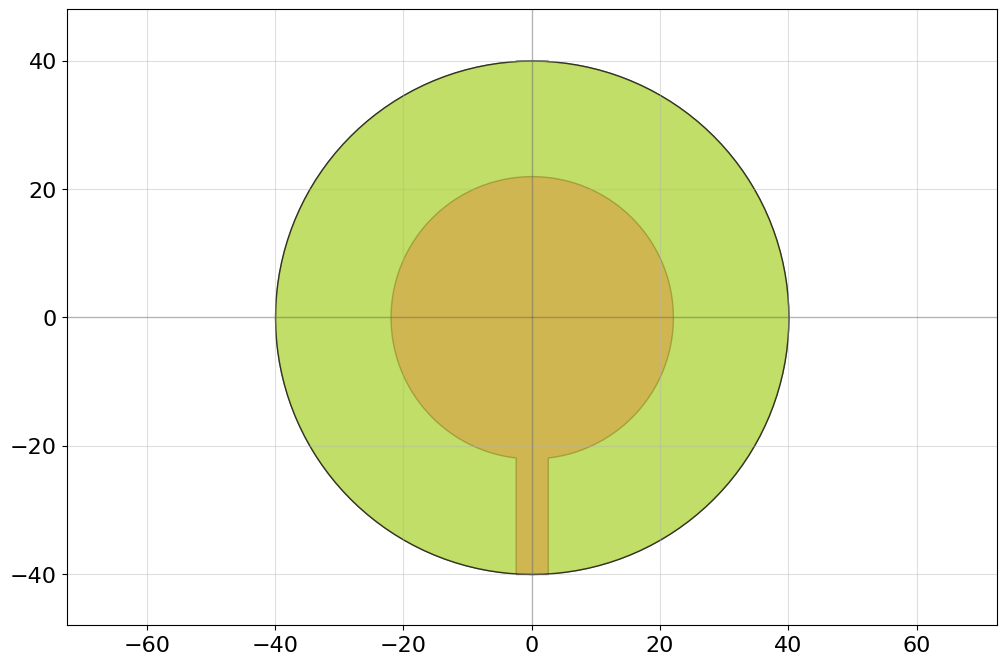

In [ ]:
my_first_pmut.draw_pMUT()
qp(my_first_pmut.layout)

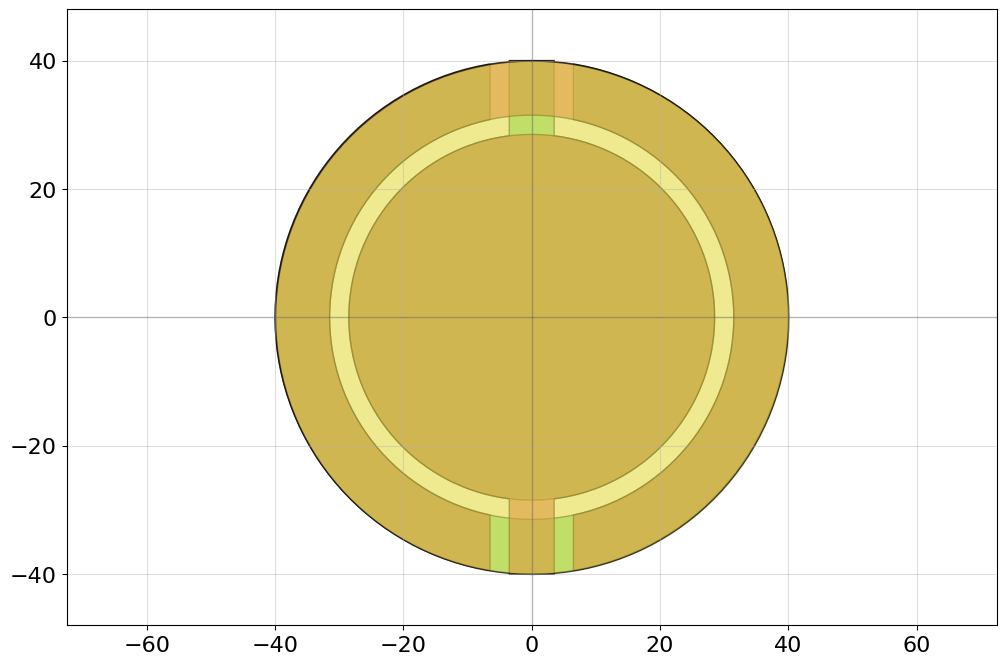

In [ ]:
my_second_pmut = Individual_Bipolar_pMUT(
                    pMUT_Radius= 40e-6,                   # Radius of the pMUT in meters
                    BottomMetalLayer=0,                   # Assigned layer in the gds file
                    ViasLayer=1,                          # Assigned layer in the gds file
                    TopMetalLayer=2,                      # Assigned layer in the gds file
                    BackEtchLayer=3,                      # Assigned layer in the gds file
                    Center_Electrode_Fraction=0.75,       # Fraction of the radius occupied by the central electrode (minus half the gap if outer electrode is present)
                    Electrodes_Gap=3e-6,                  # Gap between inner and outer electrode in bipolar pMUT in meters. Does nothing in Unipolar pMUT
                    Connection_Width=7e-6,                # Width of the connection to the central electrodes in meters
                    Elastic_Material = Silicon_Oxide,     # Material taken from the Materials.py materials library
                    Elastic_Thickness = 1e-6,             # Thickness of the elastic layer in meters
                    Elastic_Stress = -100e6,              # Residual stress in the elastic layer in Pa
                    Bottom_Electrode_Material = Platinum,
                    Bottom_Electrode_Thickness = 200e-9,
                    Bottom_Electrode_Stress = 0e6,
                    Piezo_Material = ScAlN(36),
                    Piezo_Thickness = 1e-6,
                    Piezo_Stress = 200e6,
                    Top_Electrode_Material = Aluminum,
                    Top_Electrode_Thickness = 200e-9,
                    Top_Electrode_Stress = 0e6,
                    Medium_Material = Air
                    )

my_second_pmut.draw_pMUT()
qp(my_second_pmut.layout)

In [ ]:
print('Stiffnesses')
print('Keq1: ' + "{:.2f}".format(my_first_pmut.equivalent_stiffness))
print('Keq2: ' + "{:.2f}".format(my_second_pmut.equivalent_stiffness))

print('\nEigenfrequencies')
print('f01: ' + "{:.2f}".format(my_first_pmut.eigenfrequency))
print('f01: ' + "{:.2f}".format(my_second_pmut.eigenfrequency))

Stiffnesses
Keq1: 1711.18
Keq2: 5664.81

Eigenfrequencies
f01: 3301341.95
f01: 3679565.72


In [ ]:
my_second_pmut

                                         VALUE UNIT
pMUT radius                                 40   µm
Elastic layer material           Silicon Oxide    -
Elastic layer thickness                    1.0   µm
Elastic layer stress                      -100  MPa
Bottom electrode material             Platinum    -
Bottom electrode thickness                 200   nm
Bottom electrode stress                      0  MPa
Piezo layer material        36.0% Scandium AlN    -
Piezo layer thickness                      1.0   µm
Piezo layer stress                         200  MPa
Top electrode material                Aluminum    -
Top electrode thickness                    200   nm
Top electrode stress                         0  MPa

                  VALUE    UNIT                        DESCRIPTION
f_eigen           3.680   [MHz]      Resonance frequency in vacuum
f_resonance       3.675   [MHz]  Resonance frequency in the medium
Keq            5664.810   [N/m]   Equivalent stiffness of the pMUT
Meq

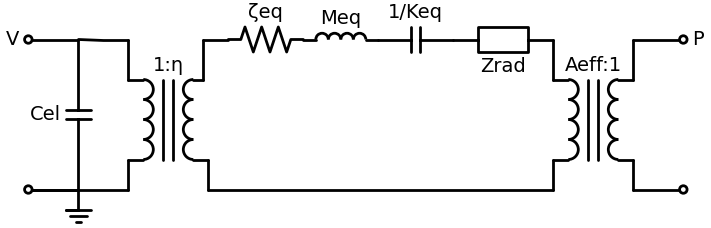

In [ ]:
my_second_pmut.eq_circuit()

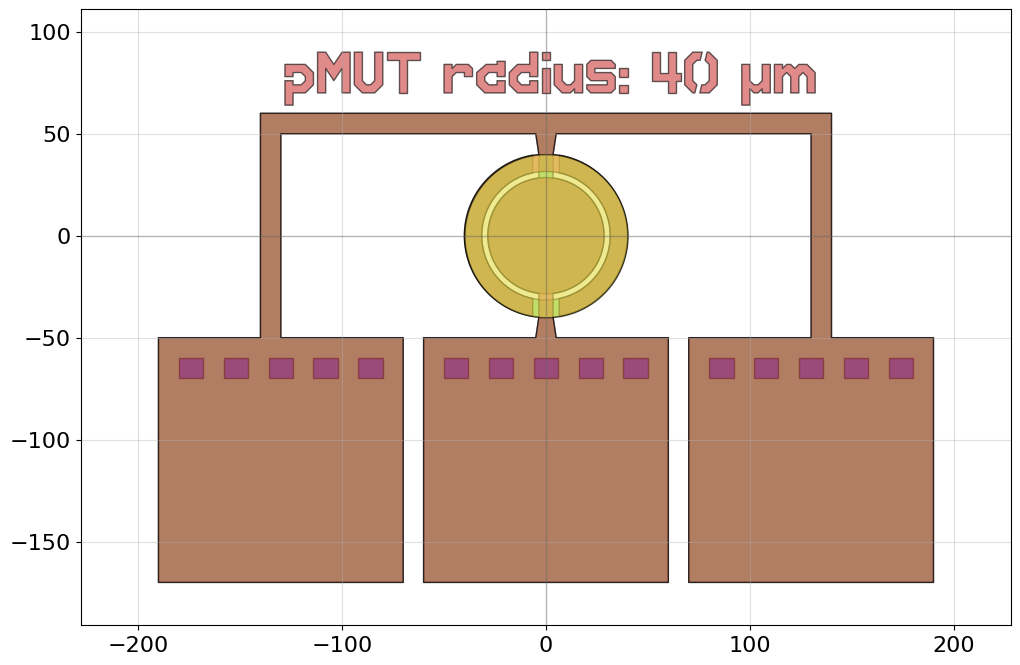

'It generates a default file "test_layout.gds", or you can pass a file name as a string argument'

In [ ]:
my_complete_pMUT = Individual_pMUT(
                pMUT_Type = my_second_pmut, # pMUT object, either Unipolar_Individual_pMUT or Bipolar_Individual_pMUT
                Pad_Size = 120e-6,          # Pads lateral dimensions
                Pad_Distance = 10e-6,       # Distance between the pads and the pMUT
                Routing_Width = 10e-6,      # Width of the metal lines
                Routing_Distance = 10e-6,   # Distance from the metal lines
                Via_Size = 10e-6,           # vertical dimenstion of the vias
                Label_Size = 20e-6          # font size of the label
                )

my_complete_pMUT.draw_layout()
qp(my_complete_pMUT.layout)

'''To draw+save to a gds file use the following method:'''

# my_complete_pMUT.draw_save_layout()

'''It generates a default file "test_layout.gds", or you can pass a file name as a string argument'''

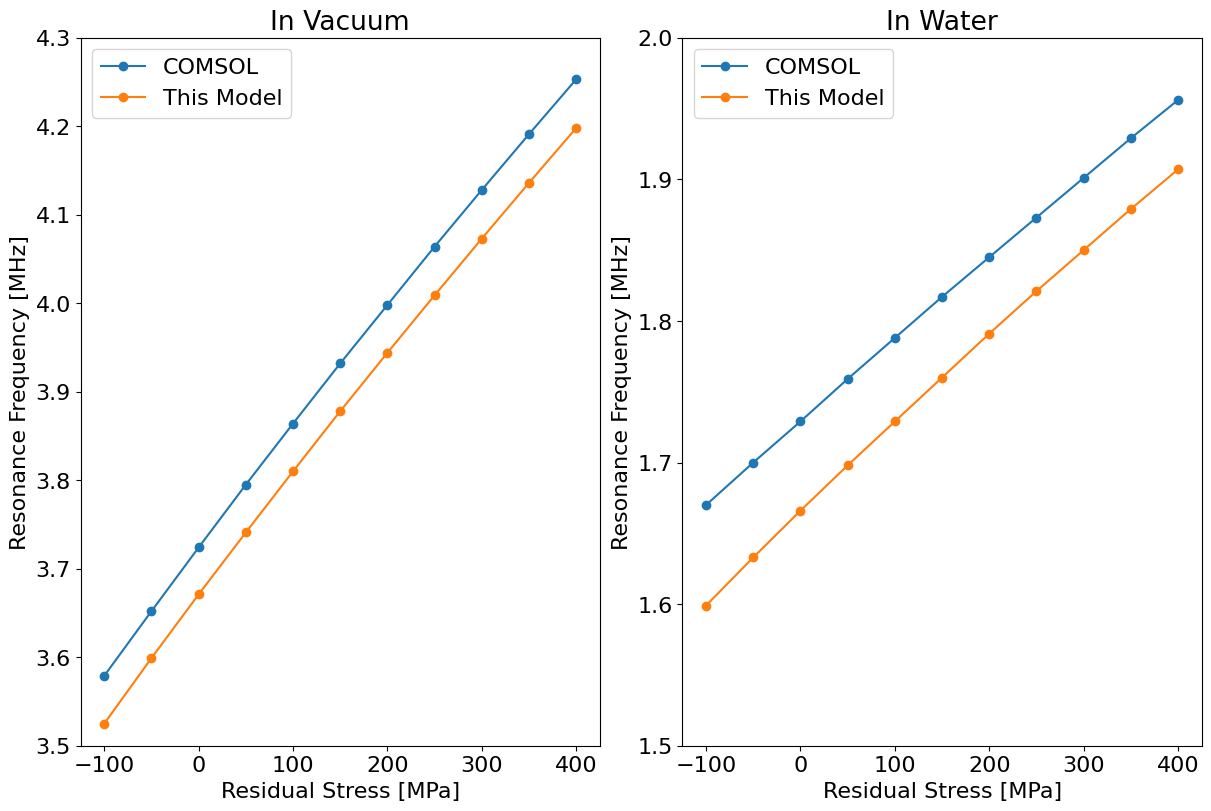

In [ ]:
# AlN stress values in  MPa
AlN_Stresses = np.linspace(-100, 400, 11)

# Models outputs in MHz
COMSOL_resonance_vac = np.array([3.579, 3.652, 3.724, 3.795, 3.864, 3.932, 3.998, 4.064, 4.128, 4.191, 4.253])
This_model_resonance_vac = np.array([3.525, 3.599, 3.671, 3.741, 3.810, 3.878, 3.944, 4.009, 4.073, 4.136, 4.198])
COMSOL_resonance_water = np.array([1.670, 1.700, 1.729, 1.759, 1.788, 1.817, 1.845, 1.873, 1.901, 1.929, 1.956])
This_model_resonance_water = np.array([1.599, 1.633, 1.666, 1.698, 1.729, 1.760, 1.791, 1.821, 1.850, 1.879, 1.907])

# Plotting
fig, ax = plt.subplots(1,2,constrained_layout = True)
ax1 = ax.flat[0]
ax2 = ax.flat[1]

ax1.set_title('In Vacuum')
ax1.set_xlabel('Residual Stress [MPa]')
ax1.set_ylabel('Resonance Frequency [MHz]')
ax1.set_ylim([3.5,4.3])

ax2.set_title('In Water')
ax2.set_xlabel('Residual Stress [MPa]')
ax2.set_ylabel('Resonance Frequency [MHz]')
ax2.set_ylim([1.5,2])

ax1.plot(AlN_Stresses, COMSOL_resonance_vac, '-o', label="COMSOL")
ax1.plot(AlN_Stresses, This_model_resonance_vac, '-o', label="This Model")
ax2.plot(AlN_Stresses, COMSOL_resonance_water, '-o', label="COMSOL")
ax2.plot(AlN_Stresses, This_model_resonance_water, '-o', label="This Model")

ax1.legend(loc='upper left')
ax2.legend(loc='upper left')
plt.show()

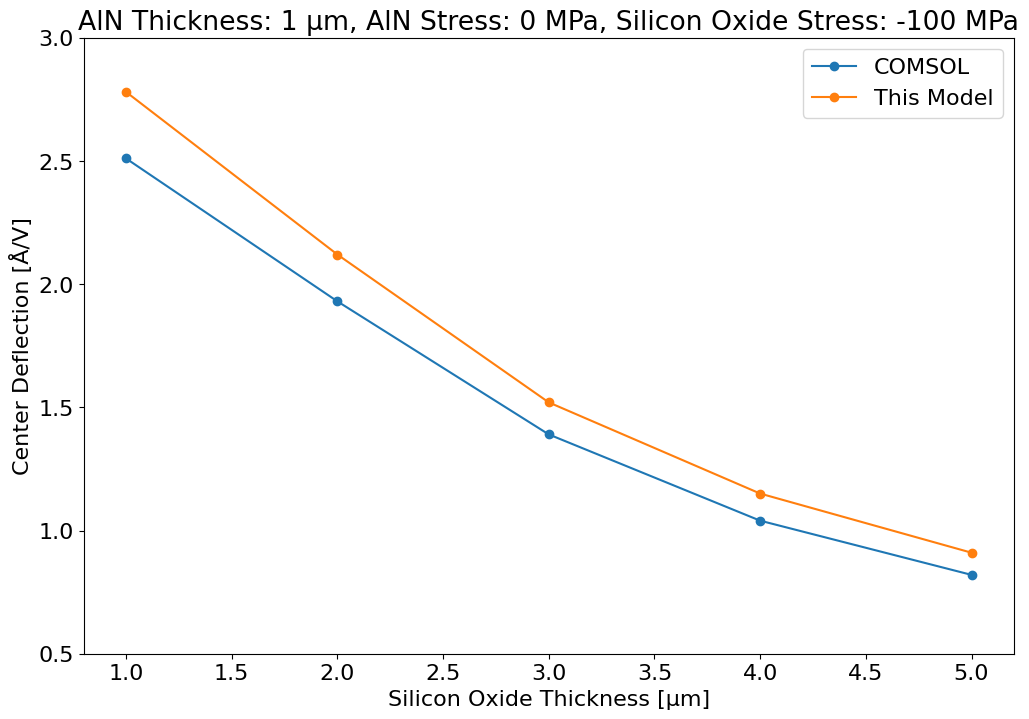

In [ ]:
this_model_deflection = np.array([2.78, 2.12, 1.52, 1.15, 0.91])
comsol_deflection = np.array([2.51, 1.93, 1.39, 1.04, 0.82])
oxide_thicknesses = np.array([1,2,3,4,5])

fig, ax = plt.subplots()
ax.plot(oxide_thicknesses, comsol_deflection, '-o', label="COMSOL")
ax.plot(oxide_thicknesses, this_model_deflection, '-o', label="This Model")

ax.set_title('AlN Thickness: 1 µm, AlN Stress: 0 MPa, Silicon Oxide Stress: -100 MPa')
ax.set_xlabel('Silicon Oxide Thickness [µm]')
ax.set_ylabel('Center Deflection [Å/V]')
ax.legend(loc='upper right')
ax.set_ylim([0.5, 3])
plt.show()

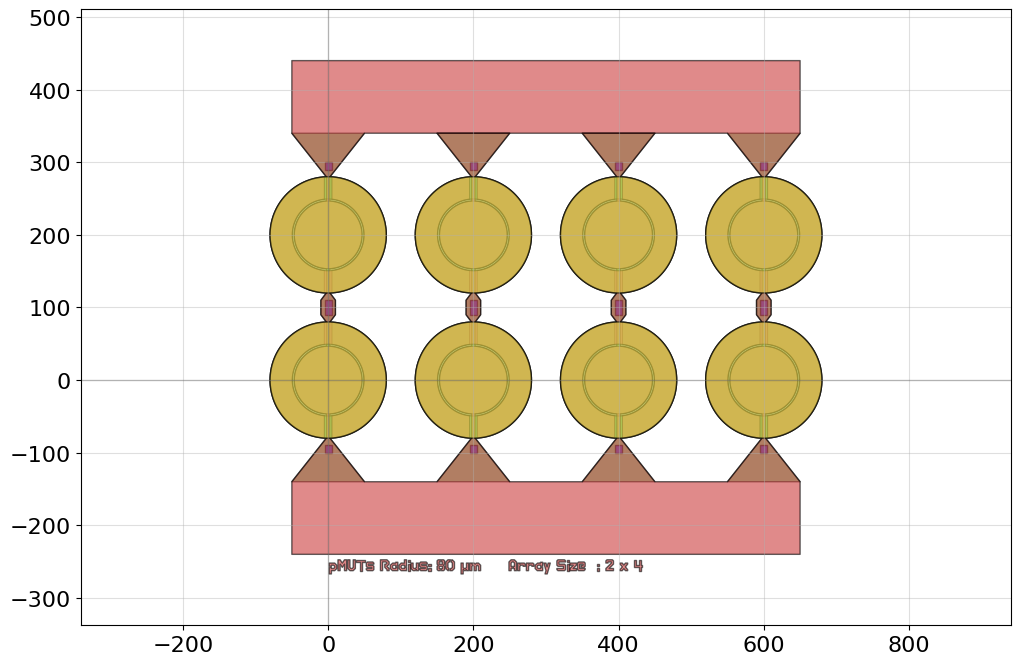

In [ ]:
# Single pMUT parameters
my_array_element = Series_Column_Array_Element_Bipolar_pMUT(
                   pMUT_Radius=80e-6,
                   BottomMetalLayer=0,
                   ViasLayer=1,
                   TopMetalLayer=2,
                   BackEtchLayer=3,
                   Center_Electrode_Fraction=0.6,
                   Electrodes_Gap=2.5e-6,
                   Connection_Width=5e-6,
                   Orientation=0,
                   Elastic_Material = Silicon_Oxide,
                   Elastic_Thickness = 1e-6,
                   Elastic_Stress = 0e6,
                   Bottom_Electrode_Material = Molybdenum,
                   Bottom_Electrode_Thickness = 100e-9,
                   Bottom_Electrode_Stress = 0e6,
                   Piezo_Material = ScAlN(36),
                   Piezo_Thickness = 0.5e-6,
                   Piezo_Stress = 0e6,
                   Top_Electrode_Material = Aluminum,
                   Top_Electrode_Thickness = 100e-9,
                   Top_Electrode_Stress = 0e6,
                   Medium_Material = Water
                   )

# pMUTs arrays parameters
my_first_array = Columns_Array(
                 pMUT_Type = my_array_element, # pMUT class to put in the array. Bipolar/Unipolar and Series/Parallel columns
                 Rows = 2,                     # Number of rows in the array
                 Columns = 4,                  # Number of columns in the array
                 Pitch = 200e-6,               # Distance between pMUTs in the array [m]
                 Pad_Size = 100e-6,            # Lateral dimensions of the array pads [m]
                 Pad_Distance = 60e-6,         # Distance of the pads from the array [m]
                 Routing_Width = 20e-6,        # Width of the connections between pMUTs [m]
                 Routing_Distance = 10e-6,     # Distance of the routings from the pMUTs [m]
                 Via_Size = 10e-6,             # Lateral dimensions of the vias [m]
                 Label_Size = 15e-6,           # Dimensions of the label at the bottom of the array [m] (can be set to zero to eliminate it)
                 Connected_Columns=False       # Only for pMUT columns with electrodes connected in parallel
                 )

my_first_array.draw_layout()
qp(my_first_array.layout)

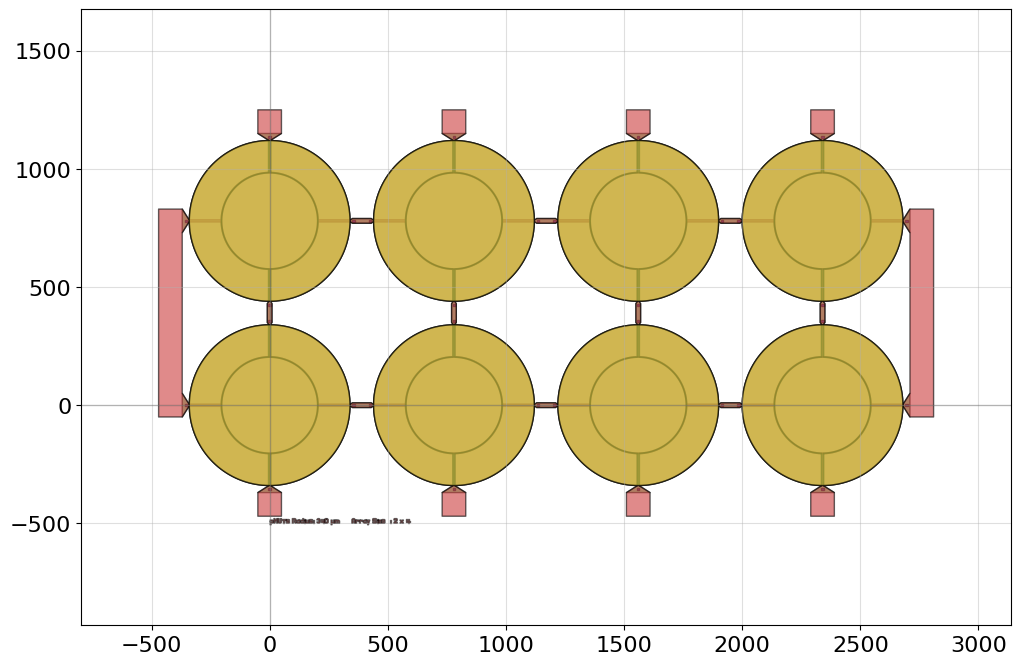

"Use the method draw_save_layout('file_name') like in the individual pMUTs case to generate a .gds file"

In [ ]:
my_array_element = Parallel_Column_Array_Element_Bipolar_pMUT( # <=== pMUT column element connected in parallel
                   pMUT_Radius=340e-6,
                   BottomMetalLayer=0,
                   ViasLayer=1,
                   TopMetalLayer=2,
                   BackEtchLayer=3,
                   Center_Electrode_Fraction=0.6,
                   Electrodes_Gap=2.5e-6,
                   Connection_Width=5e-6,
                   Orientation=0,
                   Elastic_Material = Silicon_Oxide,
                   Elastic_Thickness = 1e-6,
                   Elastic_Stress = 0e6,
                   Bottom_Electrode_Material = Molybdenum,
                   Bottom_Electrode_Thickness = 100e-9,
                   Bottom_Electrode_Stress = 0e6,
                   Piezo_Material = ScAlN(36),
                   Piezo_Thickness = 0.5e-6,
                   Piezo_Stress = 0e6,
                   Top_Electrode_Material = Aluminum,
                   Top_Electrode_Thickness = 100e-9,
                   Top_Electrode_Stress = 0e6,
                   Medium_Material = Water
                   )

my_second_array = Columns_Array(
                  pMUT_Type = my_array_element, # pMUT class to put in the array. Bipolar/Unipolar and Series/Parallel columns
                  Rows = 2,                    # Number of rows in the array
                  Columns = 4,                 # Number of columns in the array
                  Pitch = 780e-6,               # Distance between pMUTs in the array [m]
                  Pad_Size = 100e-6,            # Lateral dimensions of the array pads [m]
                  Pad_Distance = 30e-6,         # Distance of the pads from the array [m]
                  Routing_Width = 20e-6,        # Width of the connections between pMUTs [m]
                  Routing_Distance = 10e-6,     # Distance of the routings from the pMUTs [m]
                  Via_Size = 10e-6,             # Lateral dimensions of the vias [m]
                  Label_Size = 20e-6,           # Dimensions of the label at the bottom of the array [m] (can be set to zero to eliminate it)
                  Connected_Columns=False       # Only for pMUT columns with electrodes connected in parallel
                  )

my_second_array.draw_layout()
qp(my_second_array.layout)

'''Use the method draw_save_layout('file_name') like in the individual pMUTs case to generate a .gds file'''

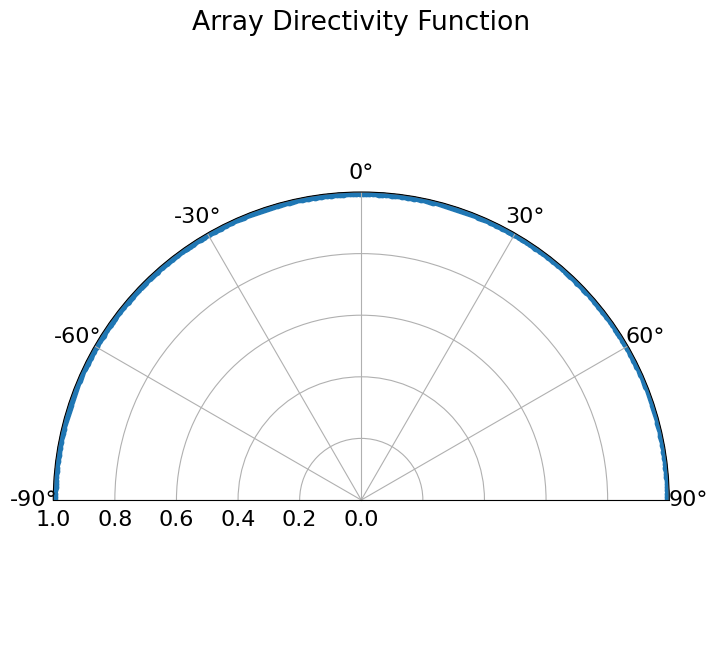

In [ ]:
my_second_array.plot_directivity_function()

4


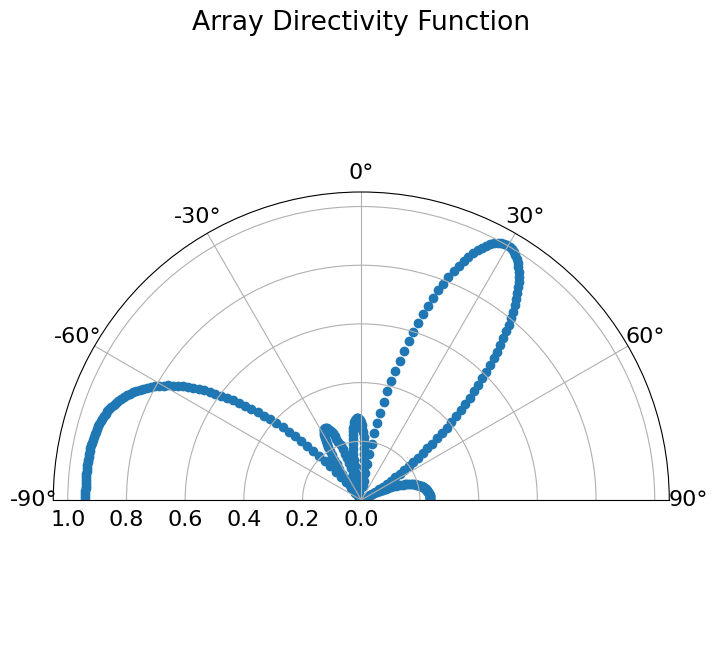

In [ ]:
N_points = 300

print(my_second_array.columns_number)
my_second_array.plot_directivity_function(
                                        thetas = np.linspace(-np.pi/2,np.pi/2,N_points), # Specify number of points you want to plot on the polar coordinate
                                        phi = 0*np.pi/2,  # Currently set along the x-axis. Use np.pi/2 for y-axis
                                        phases = np.linspace(-2*np.pi, 2*np.pi, my_second_array.columns_number), # column phases spaced between -90 and +90 degrees
                                        frequency = 1000e3, # Operational frequency of 500 kHz
                                        farfield = 3e-2
                                        )

In [ ]:
my_second_array

ARRAY PROPERTIES
Array size: 2 by 4
Column pMUTs connection: Parallel
Single column capacitance: 203.08 pF

pMUT ELEMENT PROPERTIES
                                         VALUE UNIT
pMUT radius                                340   µm
Elastic layer material           Silicon Oxide    -
Elastic layer thickness                    1.0   µm
Elastic layer stress                         0  MPa
Bottom electrode material           Molybdenum    -
Bottom electrode thickness                 100   nm
Bottom electrode stress                      0  MPa
Piezo layer material        36.0% Scandium AlN    -
Piezo layer thickness                      0.5   µm
Piezo layer stress                           0  MPa
Top electrode material                Aluminum    -
Top electrode thickness                    100   nm
Top electrode stress                         0  MPa

                     VALUE    UNIT                        DESCRIPTION
f_eigen              0.042   [MHz]      Resonance frequency in vacuum

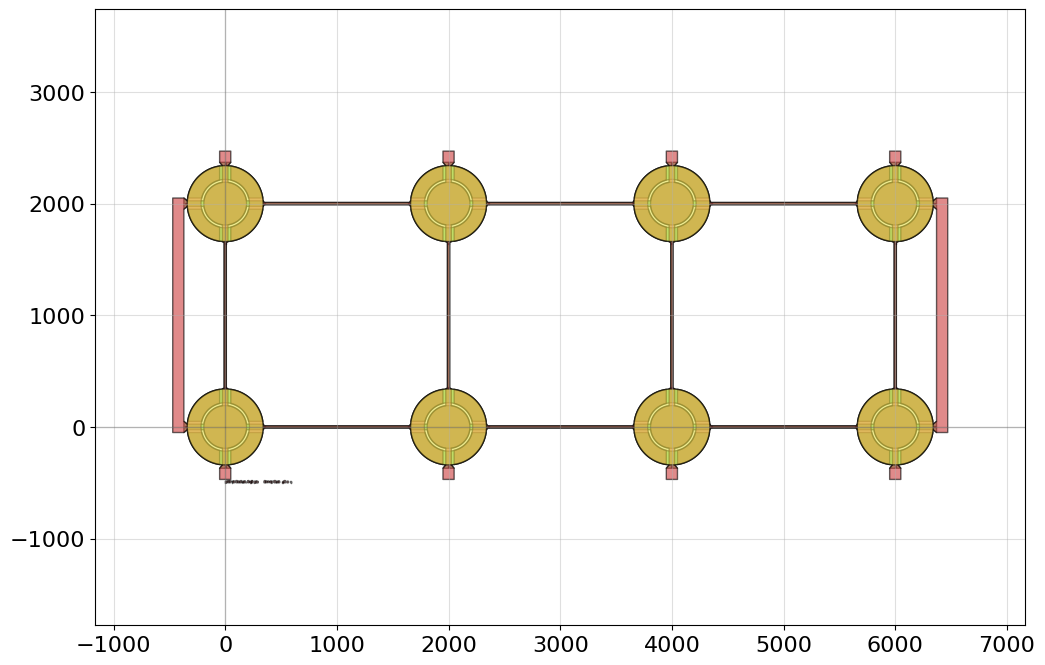

"Use the method draw_save_layout('file_name') like in the individual pMUTs case to generate a .gds file"

In [ ]:
my_array_element = Parallel_Column_Array_Element_Bipolar_pMUT( # <=== pMUT column element connected in parallel
                   pMUT_Radius=340e-6,
                   BottomMetalLayer=0,
                   ViasLayer=1,
                   TopMetalLayer=2,
                   BackEtchLayer=3,
                   Center_Electrode_Fraction=0.6,
                   Electrodes_Gap=25e-6,
                   Connection_Width=50e-6,
                   Orientation=0,
                   Elastic_Material = Silicon_Oxide,
                   Elastic_Thickness = 1e-6,
                   Elastic_Stress = 0e6,
                   Bottom_Electrode_Material = Molybdenum,
                   Bottom_Electrode_Thickness = 100e-9,
                   Bottom_Electrode_Stress = 0e6,
                   Piezo_Material = ScAlN(36),
                   Piezo_Thickness = 0.5e-6,
                   Piezo_Stress = 0e6,
                   Top_Electrode_Material = Aluminum,
                   Top_Electrode_Thickness = 100e-9,
                   Top_Electrode_Stress = 0e6,
                   Medium_Material = Water
                   )

my_mid_second_array = Columns_Array(
                  pMUT_Type = my_array_element, # pMUT class to put in the array. Bipolar/Unipolar and Series/Parallel columns
                  Rows = 2,                    # Number of rows in the array
                  Columns = 4,                 # Number of columns in the array
                  Pitch = 2000e-6,               # Distance between pMUTs in the array [m]
                  Pad_Size = 100e-6,            # Lateral dimensions of the array pads [m]
                  Pad_Distance = 30e-6,         # Distance of the pads from the array [m]
                  Routing_Width = 20e-6,        # Width of the connections between pMUTs [m]
                  Routing_Distance = 10e-6,     # Distance of the routings from the pMUTs [m]
                  Via_Size = 10e-6,             # Lateral dimensions of the vias [m]
                  Label_Size = 20e-6,           # Dimensions of the label at the bottom of the array [m] (can be set to zero to eliminate it)
                  Connected_Columns=False       # Only for pMUT columns with electrodes connected in parallel
                  )

my_mid_second_array.draw_layout()
qp(my_mid_second_array.layout)

'''Use the method draw_save_layout('file_name') like in the individual pMUTs case to generate a .gds file'''

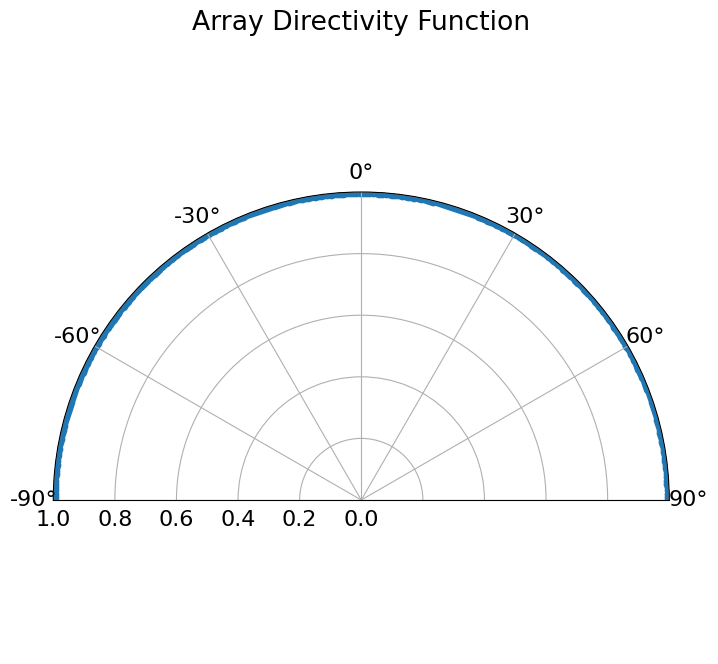

In [ ]:
my_mid_second_array.plot_directivity_function()

4


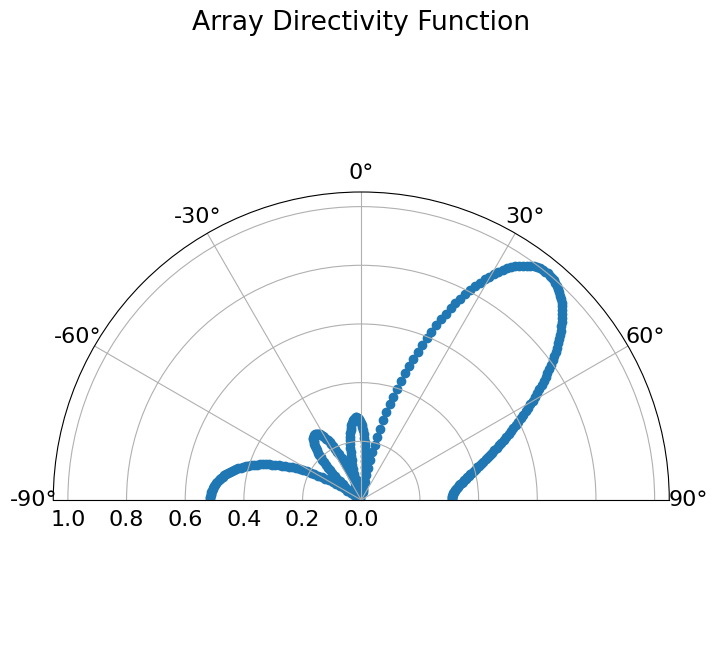

In [ ]:
N_points = 300

print(my_mid_second_array.columns_number)
my_second_array.plot_directivity_function(
                                        thetas = np.linspace(-np.pi/2,np.pi/2,N_points), # Specify number of points you want to plot on the polar coordinate
                                        phi = 0*np.pi/2,  # Currently set along the x-axis. Use np.pi/2 for y-axis
                                        phases = np.linspace(-2*np.pi, 2*np.pi, my_second_array.columns_number), # column phases spaced between -90 and +90 degrees
                                        frequency = 1000e3, # Operational frequency of 500 kHz
                                        farfield = 3e-2
                                        )

In [ ]:
example_second_array

NameError: name 'example_second_array' is not defined

In [ ]:
pip install pyvisa

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.7/176.7 kB 2.7 MB/s eta 0:00:00


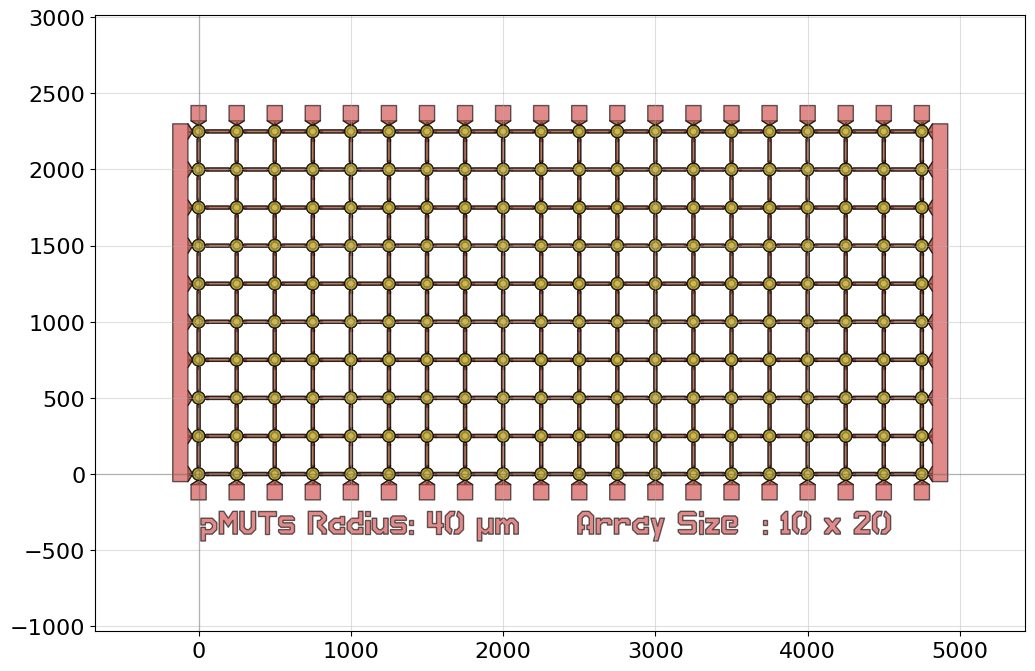

"Use the method draw_save_layout('file_name') like in the individual pMUTs case to generate a .gds file"

In [ ]:
my_array_element = Parallel_Column_Array_Element_Bipolar_pMUT( # <=== pMUT column element connected in parallel
                   pMUT_Radius=40e-6,
                   BottomMetalLayer=0,
                   ViasLayer=1,
                   TopMetalLayer=2,
                   BackEtchLayer=3,
                   Center_Electrode_Fraction=0.6,
                   Electrodes_Gap=2.5e-6,
                   Connection_Width=5e-6,
                   Orientation=0,
                   Elastic_Material = Silicon_Oxide,
                   Elastic_Thickness = 1e-6,
                   Elastic_Stress = 0e6,
                   Bottom_Electrode_Material = Molybdenum,
                   Bottom_Electrode_Thickness = 100e-9,
                   Bottom_Electrode_Stress = 0e6,
                   Piezo_Material = ScAlN(36),
                   Piezo_Thickness = 0.5e-6,
                   Piezo_Stress = 0e6,
                   Top_Electrode_Material = Aluminum,
                   Top_Electrode_Thickness = 100e-9,
                   Top_Electrode_Stress = 0e6,
                   Medium_Material = Water
                   )

example_second_array = Columns_Array(
                  pMUT_Type = my_array_element, # pMUT class to put in the array. Bipolar/Unipolar and Series/Parallel columns
                  Rows = 10,                    # Number of rows in the array
                  Columns = 20,                 # Number of columns in the array
                  Pitch = 250e-6,               # Distance between pMUTs in the array [m]
                  Pad_Size = 100e-6,            # Lateral dimensions of the array pads [m]
                  Pad_Distance = 30e-6,         # Distance of the pads from the array [m]
                  Routing_Width = 20e-6,        # Width of the connections between pMUTs [m]
                  Routing_Distance = 10e-6,     # Distance of the routings from the pMUTs [m]
                  Via_Size = 10e-6,             # Lateral dimensions of the vias [m]
                  Label_Size = 150e-6,           # Dimensions of the label at the bottom of the array [m] (can be set to zero to eliminate it)
                  Connected_Columns=False       # Only for pMUT columns with electrodes connected in parallel
                  )

example_second_array.draw_layout()
qp(example_second_array.layout)

'''Use the method draw_save_layout('file_name') like in the individual pMUTs case to generate a .gds file'''

In [ ]:
example_second_array.draw_save_layout()
import os
print(os.getcwd())

/content


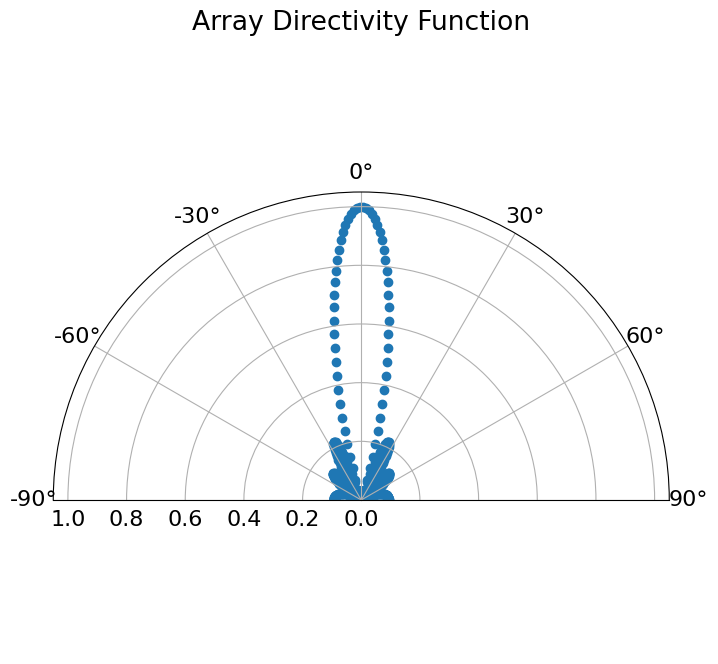

In [ ]:
example_second_array.plot_directivity_function()

20


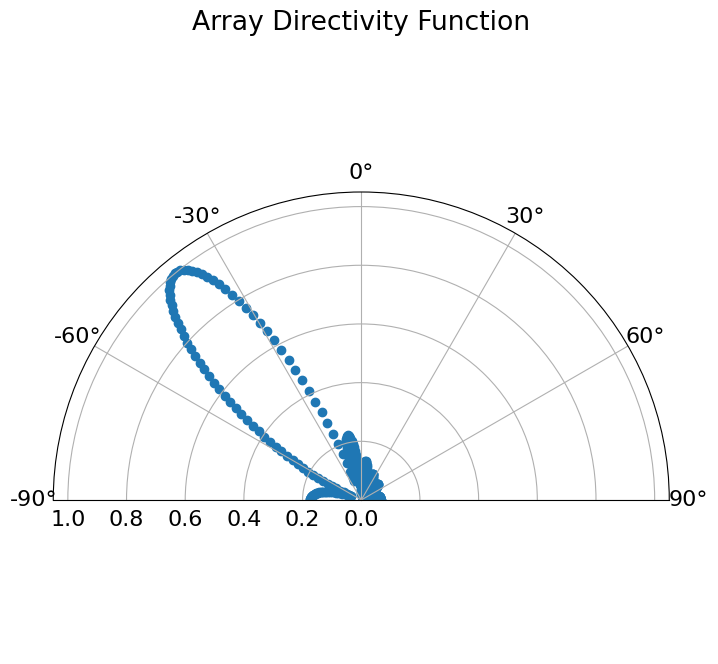

In [ ]:
N_points = 300

print(example_second_array.columns_number)
example_second_array.plot_directivity_function(
                                        thetas = np.linspace(-np.pi/2,np.pi/2,N_points), # Specify number of points you want to plot on the polar coordinate
                                        phi = 0*np.pi/2,  # Currently set along the x-axis. Use np.pi/2 for y-axis
                                        phases = np.linspace(-2*np.pi, 2*np.pi, example_second_array.columns_number), # column phases spaced between -90 and +90 degrees
                                        frequency = 1000e3, # Operational frequency of 500 kHz
                                        farfield = 3e-2
                                        )

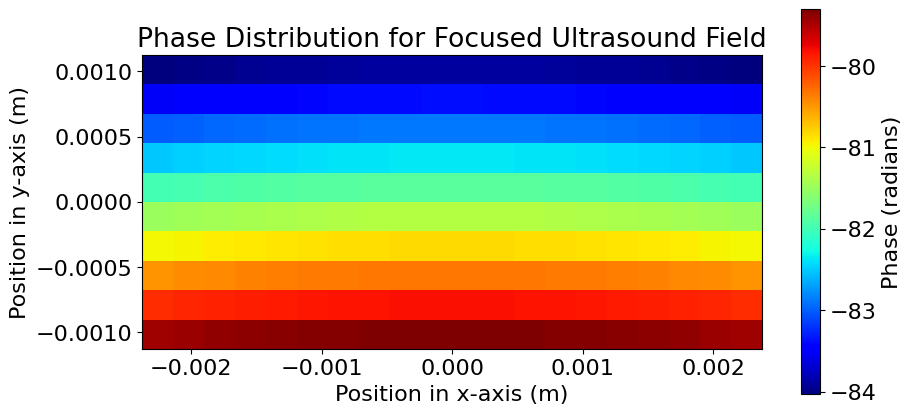

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Constants
frequency = 500e3  # frequency of ultrasound in Hz
speed_of_sound = 1540  # speed of sound in m/s (typical for soft tissues)
wavelength = speed_of_sound / frequency

# Array configuration
num_columns = 20  # Number of elements in each column
num_rows = 10  # Number of rows
element_spacing = 250e-6  # Distance between elements in meters

# Target focal point (depth in meters, and at the center transversely)
focal_depth = 0.04  # 50 mm
focal_point_x = 0  # Centered

# Calculate phase delays
phases = np.zeros((num_rows, num_columns))
element_positions_x = np.linspace(-(num_columns - 1) / 2, (num_columns - 1) / 2, num_columns) * element_spacing
element_positions_y = np.linspace(-(num_rows - 1) / 2, (num_rows - 1) / 2, num_rows) * element_spacing

# Computing the required phase for each element
for i in range(num_rows):
    for j in range(num_columns):
        # Distance from element to focal point
        distance = np.sqrt((element_positions_x[j] - focal_point_x)**2 + (element_positions_y[i] - focal_depth)**2)
        # Required phase shift
        phases[i, j] = -2 * np.pi * distance / wavelength

# Plotting the phase distribution
plt.figure(figsize=(10, 5))
plt.imshow(phases, extent=[element_positions_x[0], element_positions_x[-1], element_positions_y[0], element_positions_y[-1]], cmap='jet')
plt.colorbar(label='Phase (radians)')
plt.title('Phase Distribution for Focused Ultrasound Field')
plt.xlabel('Position in x-axis (m)')
plt.ylabel('Position in y-axis (m)')
plt.show()

# To visualize the directivity pattern, you would integrate this phase information into your array driving function.


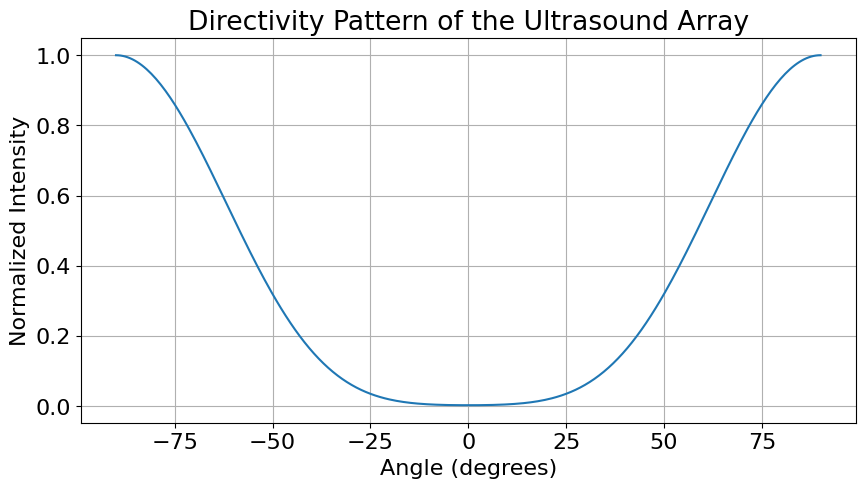

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Constants
frequency = 300e3  # Ultrasound frequency in Hz
speed_of_sound = 1540  # Speed of sound in m/s (typical for soft tissues)
wavelength = speed_of_sound / frequency

# Array Configuration
num_columns = 20  # Number of elements in each column
num_rows = 10  # Number of rows
element_spacing = 250e-6  # Distance between elements in meters
focal_depth = 0.05  # Focal depth in meters

# Grid for simulation
angles = np.linspace(-np.pi / 2, np.pi / 2, 300)  # Angles from -90 to 90 degrees
field = np.zeros(len(angles), dtype=np.complex64)

# Calculate element positions
element_positions_x = np.linspace(-(num_columns - 1) / 2, (num_columns - 1) / 2, num_columns) * element_spacing
element_positions_y = np.linspace(-(num_rows - 1) / 2, (num_rows - 1) / 2, num_rows) * element_spacing

# Compute the required phase for each element
for i in range(num_rows):
    for j in range(num_columns):
        # Distance from element to the focal point on the axis
        distance = np.sqrt(element_positions_x[j]**2 + element_positions_y[i]**2 + focal_depth**2)
        phase = -2 * np.pi * distance / wavelength

        # Add the contribution of this element to the field at each angle
        for k, angle in enumerate(angles):
            # Calculate the projection of the element position on the wave direction
            d = element_positions_x[j] * np.cos(angle) + element_positions_y[i] * np.sin(angle)
            # Add the contribution of this element to the field
            field[k] += np.exp(1j * (2 * np.pi * d / wavelength + phase))

# Calculate the magnitude of the field
field_magnitude = np.abs(field) ** 2
field_magnitude /= np.max(field_magnitude)  # Normalize

# Plotting the directivity pattern
plt.figure(figsize=(10, 5))
plt.plot(angles * 180 / np.pi, field_magnitude)
plt.title('Directivity Pattern of the Ultrasound Array')
plt.xlabel('Angle (degrees)')
plt.ylabel('Normalized Intensity')
plt.grid(True)
plt.show()


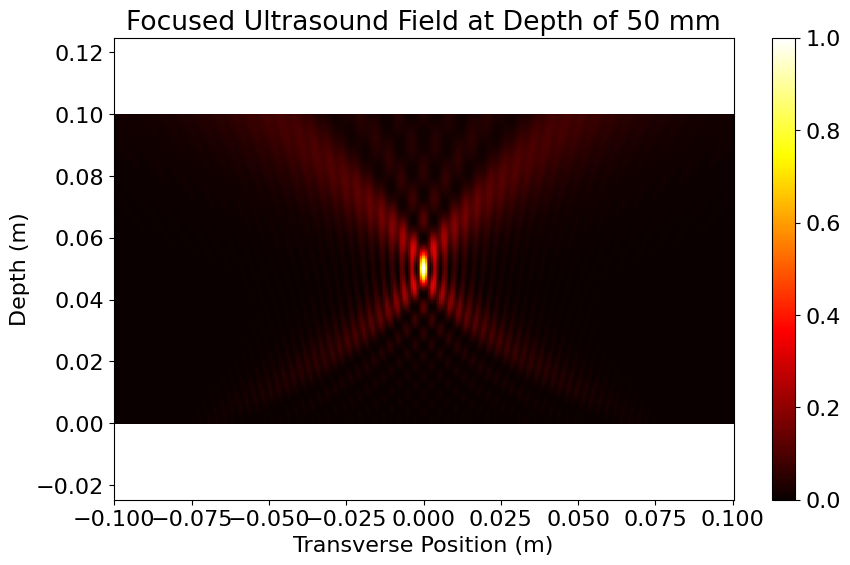

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
frequency = 300e3  # frequency of the ultrasound in Hz
speed_of_sound = 1540  # speed of sound in m/s (typical for soft tissues)
wavelength = speed_of_sound / frequency
element_spacing = wavelength / 2  # half-wavelength spacing
num_elements = 64  # number of elements in the array
focal_depth = 50e-3  # focal depth in meters

# Simulation grid
x = np.linspace(-0.1, 0.1, 400)
y = np.linspace(0, 0.1, 400)
X, Y = np.meshgrid(x, y)

# Calculate the phase delays needed for focusing at focal_depth
element_positions = np.linspace(-(num_elements - 1) / 2, (num_elements - 1) / 2, num_elements) * element_spacing
phases = 2 * np.pi / wavelength * (np.sqrt(element_positions**2 + focal_depth**2) - focal_depth)

# Calculate the field pattern
field = np.zeros(X.shape, dtype=np.complex64)
for idx, position in enumerate(element_positions):
    distance = np.sqrt((X - position)**2 + Y**2)
    field += np.exp(1j * (2 * np.pi * distance / wavelength - phases[idx]))

field_magnitude = np.abs(field)**2
field_magnitude /= np.max(field_magnitude)  # normalize

# Plot the result
plt.figure(figsize=(10, 6))
plt.pcolormesh(x, y, field_magnitude, shading='auto', cmap='hot')
plt.colorbar()
plt.title('Focused Ultrasound Field at Depth of 50 mm')
plt.xlabel('Transverse Position (m)')
plt.ylabel('Depth (m)')
plt.axis('equal')
plt.show()


Phase shifts for each element (in radians):
Element 1: 55.16
Element 2: 52.50
Element 3: 49.86
Element 4: 47.25
Element 5: 44.67
Element 6: 42.13
Element 7: 39.61
Element 8: 37.13
Element 9: 34.70
Element 10: 32.30
Element 11: 29.95
Element 12: 27.64
Element 13: 25.39
Element 14: 23.20
Element 15: 21.07
Element 16: 19.00
Element 17: 17.01
Element 18: 15.09
Element 19: 13.26
Element 20: 11.52
Element 21: 9.87
Element 22: 8.32
Element 23: 6.89
Element 24: 5.57
Element 25: 4.38
Element 26: 3.32
Element 27: 2.39
Element 28: 1.61
Element 29: 0.98
Element 30: 0.50
Element 31: 0.18
Element 32: 0.02
Element 33: 0.02
Element 34: 0.18
Element 35: 0.50
Element 36: 0.98
Element 37: 1.61
Element 38: 2.39
Element 39: 3.32
Element 40: 4.38
Element 41: 5.57
Element 42: 6.89
Element 43: 8.32
Element 44: 9.87
Element 45: 11.52
Element 46: 13.26
Element 47: 15.09
Element 48: 17.01
Element 49: 19.00
Element 50: 21.07
Element 51: 23.20
Element 52: 25.39
Element 53: 27.64
Element 54: 29.95
Element 55: 32.30

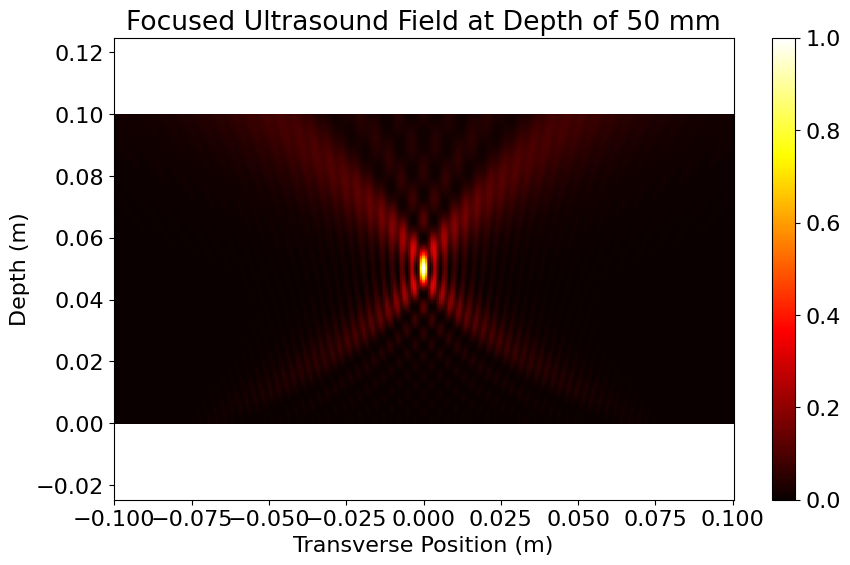

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
frequency = 300e3  # frequency of the ultrasound in Hz
speed_of_sound = 1540  # speed of sound in m/s (typical for soft tissues)
wavelength = speed_of_sound / frequency
element_spacing = wavelength / 2  # half-wavelength spacing
num_elements = 64  # number of elements in the array
focal_depth = 50e-3  # focal depth in meters

# Simulation grid
x = np.linspace(-0.1, 0.1, 400)
y = np.linspace(0, 0.1, 400)
X, Y = np.meshgrid(x, y)

# Calculate the phase delays needed for focusing at focal_depth
element_positions = np.linspace(-(num_elements - 1) / 2, (num_elements - 1) / 2, num_elements) * element_spacing
phases = 2 * np.pi / wavelength * (np.sqrt(element_positions**2 + focal_depth**2) - focal_depth)

# Print phase shifts
print("Phase shifts for each element (in radians):")
for idx, phase in enumerate(phases):
    print(f"Element {idx+1}: {phase:.2f}")

# Calculate the field pattern
field = np.zeros(X.shape, dtype=np.complex64)
for idx, position in enumerate(element_positions):
    distance = np.sqrt((X - position)**2 + Y**2)
    field += np.exp(1j * (2 * np.pi * distance / wavelength - phases[idx]))

field_magnitude = np.abs(field)**2
field_magnitude /= np.max(field_magnitude)  # normalize

# Plot the result
plt.figure(figsize=(10, 6))
plt.pcolormesh(x, y, field_magnitude, shading='auto', cmap='hot')
plt.colorbar()
plt.title('Focused Ultrasound Field at Depth of 50 mm')
plt.xlabel('Transverse Position (m)')
plt.ylabel('Depth (m)')
plt.axis('equal')
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
frequency = 300e3  # frequency of the ultrasound in Hz
speed_of_sound = 1540  # speed of sound in m/s (typical for soft tissues)
wavelength = speed_of_sound / frequency
element_spacing = wavelength / 2  # half-wavelength spacing
num_elements_x = 64  # number of elements in each row
num_elements_y = 2    # number of rows
focal_depth = 50e-3  # focal depth in meters

# Simulation grid
x = np.linspace(-0.1, 0.1, 400)
y = np.linspace(0, 0.1, 400)
X, Y = np.meshgrid(x, y)

# Calculate the phase delays needed for focusing at focal_depth
element_positions_x = np.linspace(-(num_elements_x - 1) / 2, (num_elements_x - 1) / 2, num_elements_x) * element_spacing
element_positions_y = np.linspace(-(num_elements_y - 1) / 2, (num_elements_y - 1) / 2, num_elements_y) * element_spacing
phases = np.zeros((num_elements_y, num_elements_x))

# Calculate the field pattern
field = np.zeros(X.shape, dtype=np.complex64)
for i in range(num_elements_y):
    for j in range(num_elements_x):
        position_x = element_positions_x[j]
        position_y = element_positions_y[i]
        distance = np.sqrt((X - position_x)**2 + (Y - position_y)**2)
        phases[i, j] = 2 * np.pi / wavelength * (distance - focal_depth)
        field += np.exp(1j * (2 * np.pi * distance / wavelength - phases[i, j]))

field_magnitude = np.abs(field)**2
field_magnitude /= np.max(field_magnitude)  # normalize

# Plot the result
plt.figure(figsize=(10, 6))
plt.pcolormesh(x, y, field_magnitude, shading='auto', cmap='hot')
plt.colorbar()
plt.title('Focused Ultrasound Field at Depth of 50 mm (2x64 Array)')
plt.xlabel('Transverse Position (m)')
plt


ValueError: setting an array element with a sequence.

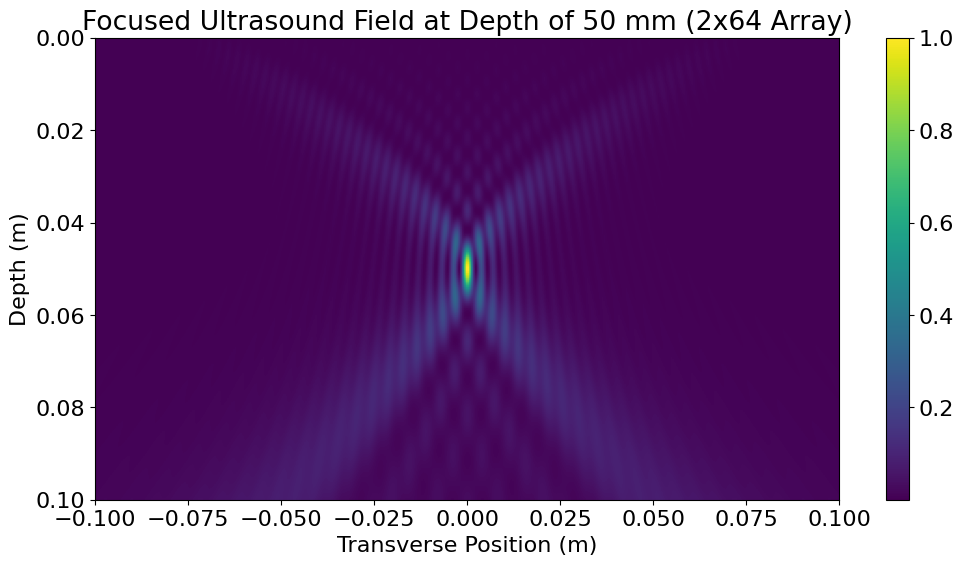

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Constants
frequency = 300e3  # Hz
speed_of_sound = 1540  # m/s
wavelength = speed_of_sound / frequency

# Array configuration
num_elements_x = 64
num_elements_y = 2
element_spacing = wavelength / 2

# Focus target
focal_point = [0, 0.05]  # Focusing at 50 mm depth, center

# Grid for simulation
x = np.linspace(-0.1, 0.1, 400)
y = np.linspace(0, 0.1, 200)
X, Y = np.meshgrid(x, y)

# Array element positions
element_positions_x = np.linspace(-(num_elements_x - 1) / 2, (num_elements_x - 1) / 2, num_elements_x) * element_spacing
element_positions_y = np.linspace(-(num_elements_y - 1) / 2, (num_elements_y - 1) / 2, num_elements_y) * element_spacing

# Calculate the field pattern
field = np.zeros(X.shape, dtype=np.complex128)
for i in range(num_elements_y):
    for j in range(num_elements_x):
        position_x = element_positions_x[j]
        position_y = element_positions_y[i]
        # Distance from each element to each point on the grid
        distance = np.sqrt((X - position_x)**2 + (Y - position_y)**2)
        # Calculating the delay required to focus at focal_point
        distance_to_focus = np.sqrt((focal_point[0] - position_x)**2 + (focal_point[1] - position_y)**2)
        # Phase adjustment to focus at the specific depth
        phase = 2 * np.pi * (distance - distance_to_focus) / wavelength
        # Summing contributions from each element
        field += np.exp(-1j * phase)

# Field magnitude
field_magnitude = np.abs(field)**2
field_magnitude /= np.max(field_magnitude)  # normalization

# Plotting
plt.figure(figsize=(12, 6))
plt.imshow(field_magnitude, extent=(x.min(), x.max(), y.max(), y.min()), cmap='viridis', aspect='auto')
plt.colorbar()
plt.title('Focused Ultrasound Field at Depth of 50 mm (2x64 Array)')
plt.xlabel('Transverse Position (m)')
plt.ylabel('Depth (m)')
plt.show()


In [ ]:
import numpy as np

# Constants
c_water = 1500  # Speed of sound in water (m/s)

# pMUT properties from your specifications
frequency = 1.018e6  # Resonance frequency in the medium (Hz)
Keq = 1897.227       # Equivalent stiffness (N/m)
Meq = 5.274e-12      # Equivalent mass (kg)

# Array dimensions
num_rows = 10        # Number of rows in the array
num_columns = 20     # Number of columns in the array
pitch = 250e-6       # Pitch - distance between pMUTs in the array (m)

# Calculate diameter of the array (assuming a rectangular layout)
D = num_columns * pitch  # Approximation for focusing calculation

# Calculate wavelength in water
wavelength = c_water / frequency

# Calculate focal depth
focal_depth = D**2 / (4 * wavelength)

# Print results
print(f"Resonant Frequency: {frequency/1e6:.3f} MHz")
print(f"Focal Depth: {focal_depth:.3f} m")


Resonant Frequency: 1.018 MHz
Focal Depth: 0.004 m
